In [1]:
# plotter for the Wiener SVD unfolding output ROOT file
# background subtract before running through WienerSVD
# compute the cross section AFTER unfolding 

In [2]:
import numpy as np

# This is our configuration file, cfg.py, which contains the variable names and related info.
import cfg
from cfg import *


In [3]:
ISOLD = False

ISRUN3 = False      # leave empty for FHC+RHC

isNuWro = False

isClosureTest = True

isData = True

cut_level = "" 

# Choose your variable!
# Variables = "Opening Angle", "Proton Multiplicity", "Electron Energy", "Visible Energy"
name_of_variable = "Opening Angle" 
xvar, true_var, bins, xlow, xhigh, x_label, x_ticks = get_variable_info(name_of_variable, ISRUN3, cut_level)

# ELECTRON ENERGY: 0603 for new flux, 0602 for old flux, 0618 for no shower energy correction
# VISIBLE ENERGY: 071524 for new flux 

From cfg.py...
Variable definition: Opening Angle
Reconstructed variable = tksh_angle
True variable = opening_angle
Bins = [-1.0, -0.5, -0.174, 0.174, 0.5, 1.0]
Lowest x-value on plot = -1.0
Highest x-value on plot = 1.0
x-axis title = $\cos{\theta_{\mathrm{ep}}}$
x-axis labels = [-1.0, -0.5, -0.174, 0.174, 0.5, 1.0]


In [4]:
# Default path and filename
path = "/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/unfolding/unblinded/output/"
c = "1"  # Use this to change your value of C!
file = "output_" + xvar + "_Combined_C" + c + ".root"

# Check if isNuWro is True, and set a different path and filename
if isNuWro:
    path = "/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/unfolding/unblinded/nuwro_output/"  # New path for NuWro output
    file = "output_nuwro_" + xvar + "_C" + c + ".root"  # New filename format for NuWro

if isClosureTest:
    path = "/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/unfolding/unblinded/closure_test/"
    file = "output_new_" + xvar + "_Combined_C" + c + ".root"

# You can now use the updated path and file variables for saving the file
print("Saving file to:", path + file)


Saving file to: /Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/unfolding/unblinded/closure_test/output_new_tksh_angle_Combined_C1.root


In [5]:
import sys
sys.path.insert(0, 'backend_functions')

import importlib

import uproot
import matplotlib.pylab as pylab

from matplotlib import gridspec

import math

import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT
from ROOT import TH1F, TDirectory, TMatrixD, TH2D

import os

import top 
from top import *

/var/folders/pj/m9tfv03972l1ccvgzxkhhrdh0000gq/T/ipykernel_19743/1049381375.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Welcome to JupyROOT 6.26/10


In [6]:
import io
import json
import os
from datetime import date

In [7]:
if ISRUN3: 
    print("Using RHC values !! ")


In [8]:
f = uproot.open(path+file)
#f = uproot.open(file)

In [9]:
rho_argon = 1.3836 # g/cm^3
fv = 236*212*1016
n_a = 6.022E23
n_nucleons = 40
m_mol = 39.95 #g/mol

n_target = (rho_argon * fv * n_a * n_nucleons) / m_mol # number of targets (in nucleons)

if ISRUN3=='': 
    cv_flux = (parameters(ISRUN3=False)['integrated_flux_per_pot']*parameters(ISRUN3=False)['beamon_pot'] + parameters(ISRUN3=True)['integrated_flux_per_pot']*parameters(ISRUN3=True)['beamon_pot'])
    pot = '$7.0\\times 10^{20}$ POT'
else: 
    cv_flux = parameters(ISRUN3)['integrated_flux_per_pot']*parameters(ISRUN3)['beamon_pot']
    

In [10]:
if ISRUN3: 
    pot = '$5.0\\times 10^{20}$ POT'
    
elif ISRUN3==False: 
    pot = '$2.0\\times 10^{20}$ POT'
    

# Input spectra (true & measured)

In [11]:
h_meas = f["hmeas"]
h_true = f['htrue_signal']

In [12]:
bins = [round(var, 2) for var in h_meas.edges]

if xvar=='tksh_angle': 
    bincenters = 0.5*(np.array(x_ticks)[1:]+np.array(x_ticks)[:-1])
else: 
    # bincenters = 0.5*(np.array(x_ticks+[xhigh])[1:]+np.array(x_ticks+[xhigh])[:-1])
    bincenters = 0.5*(np.array(bins[:-1]+[xhigh])[1:]+np.array(bins[:-1]+[xhigh])[:-1])

b_meas = bins
b_true = bins

print(bincenters)

[-0.75  -0.337  0.     0.337  0.75 ]


In [13]:
binwidth_plot = []
binwidth_div = []

for x in range(len(bincenters)):
    
    if xvar=='tksh_angle': 
        binwidth_plot.append(round(abs((x_ticks)[x+1]-(x_ticks)[x])/2, 2))
        binwidth_div = [x*2 for x in binwidth_plot]
        
    else: 
        #binwidth.append(round(abs((x_ticks+[xhigh])[x+1]-(x_ticks+[xhigh])[x])/2, 2))
        binwidth_plot.append(round(abs((bins[:-1]+[xhigh])[x+1]-(bins[:-1]+[xhigh])[x])/2, 3))
        binwidth_div.append( round(abs((bins)[x+1]-(bins)[x]), 3) )
    
binwidth_div

[0.5, 0.32, 0.34, 0.32, 0.5]

In [14]:
meas = h_meas.values
true = h_true.values

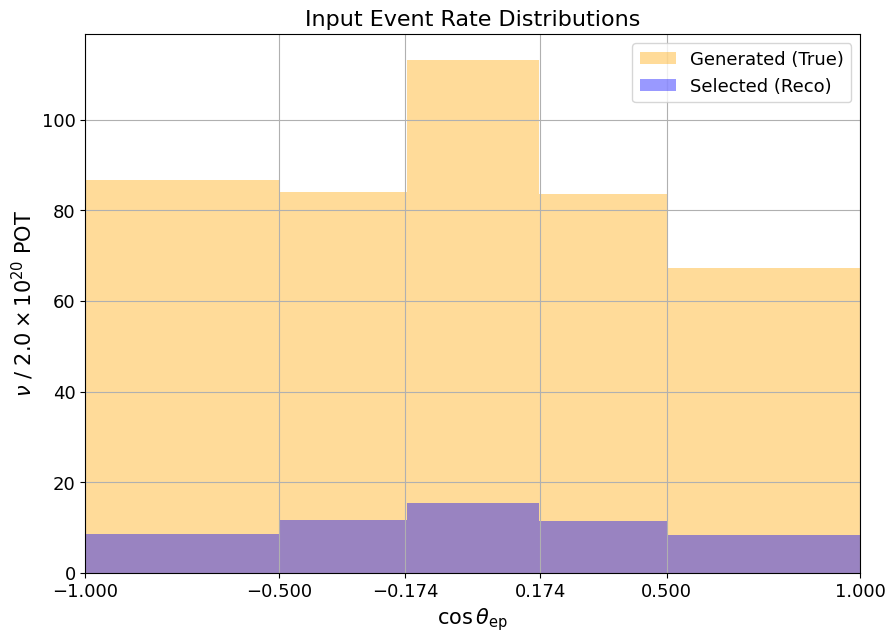

In [15]:
fig = plt.figure(figsize=(10, 7))

if isNuWro: 
    plt.hist(bincenters, bins, color='orange', label='Generated (True - GENIE v3)', alpha=0.4, weights=true)
    plt.hist(bincenters, bins, color='blue', label='Selected (Reco - NuWro)', alpha=0.4, weights=meas)
    
else: 
    plt.hist(bincenters, bins, color='orange', label='Generated (True)', alpha=0.4, weights=true)
    plt.hist(bincenters, bins, color='blue', label='Selected (Reco)', alpha=0.4, weights=meas)

plt.legend(fontsize=13)
plt.title('Input Event Rate Distributions', fontsize=16)

plt.xlim(bins[0],xhigh)
#plt.ylim(0, 225)

plt.xlabel(x_label, fontsize=15)
    
plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.grid()

if ISRUN3==False: 
    
    plt.ylabel("$\\nu$ / $2.0 \\times 10^{20}$ POT", fontsize=15)

elif ISRUN3==True: 
    plt.ylabel("$\\nu$ / $5.0 \\times 10^{20}$ POT", fontsize=15)
    
else: 
    plt.ylabel("$\\nu$ / $7.0 \\times 10^{20}$ POT", fontsize=15)

#if isData==True: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/"+xvar+"_InputDistributions_beamon.pdf", 
#                transparent=True, bbox_inches='tight') 
    
plt.show()

## input covariance matrix 

In [16]:
h_cov = f['hcov_tot']

In [17]:
b_cov = list(h_cov.edges[0])
cov = h_cov.values

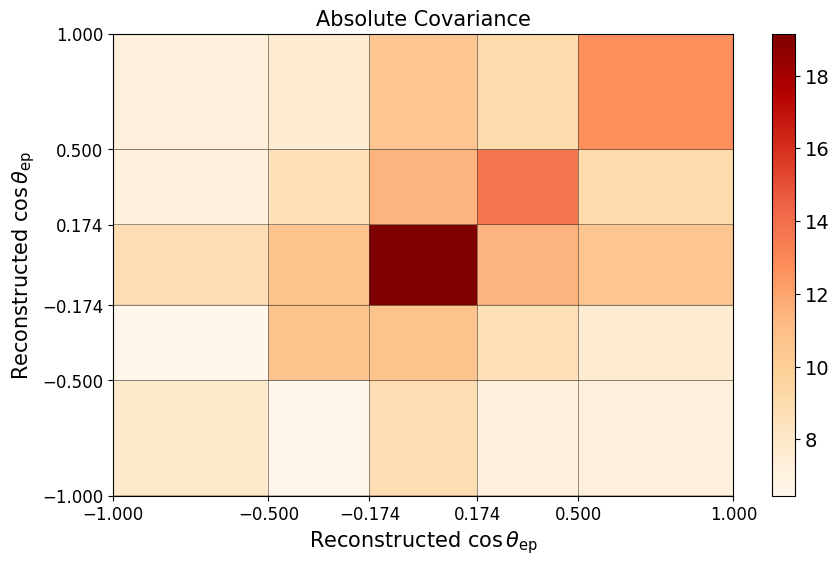

In [18]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(b_cov, b_cov, cov.T, cmap='OrRd', edgecolors='k')#, vmin=0, vmax=85)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

if ISRUN3=='': 
    cbar.set_label("$\\nu^{2}$ / $7.0 \\times 10^{20}$ POT$^{2}$", fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.ylabel("Reconstructed "+x_label, fontsize=15)

plt.title('Absolute Covariance', fontsize=15)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/"+xvar+"_tot_abs_cov_closuretest.pdf", 
#                transparent=True, bbox_inches='tight') 

#if isNuWro: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/input_cov_"+xvar+"_nuwro.pdf", 
#                transparent=True, bbox_inches='tight') 

plt.show()

## input response matrix 

In [19]:
h_res = f['hR']

In [20]:
b_res = list(h_res.edges[0])
res = h_res.values

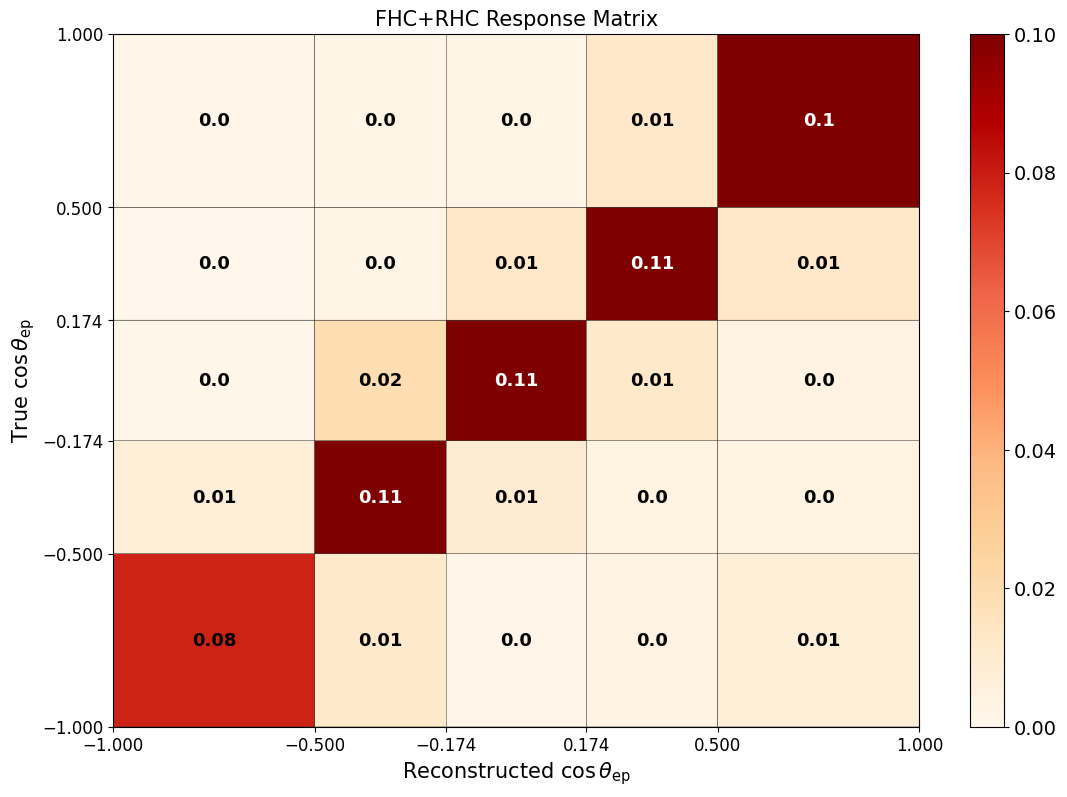

In [21]:
#fig = plt.figure(figsize=(10, 6))
fig = plt.figure(figsize=(13, 9))
        
# pcolor transposes, so account for this - 
plt.pcolor(b_res, b_res, res.T, cmap='OrRd', edgecolors='k', vmin=0, vmax=0.1)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
#cbar.set_label("$\\nu$ / 2 $\\times$ 10$^{20}$ POT (normalized)", fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

plt.xlabel("Reconstructed "+x_label, fontsize=15)
plt.ylabel("True "+x_label, fontsize=15)

for x in range(len(bins)-1): 
    for y in range(len(bins)-1): 

        if not np.isnan(res[x][y]):
            if round(res[x][y],2)>0.08: 
                plt.text(bincenters[x], bincenters[y], round(res[x][y], 2), 
                        color='white', ha="center", va="center", fontsize=13, fontweight='bold')
            else: 
                plt.text(bincenters[x], bincenters[y], round(res[x][y], 2), 
                        color='black', ha="center", va="center", fontsize=13, fontweight='bold')



plt.title('FHC+RHC Response Matrix', fontsize=15)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/"+xvar+"_rmatrix.pdf", 
#                transparent=True, bbox_inches='tight') 


plt.show()

# unfolded result

In [22]:
h_unf = f['unf']
unf = list(h_unf.values)

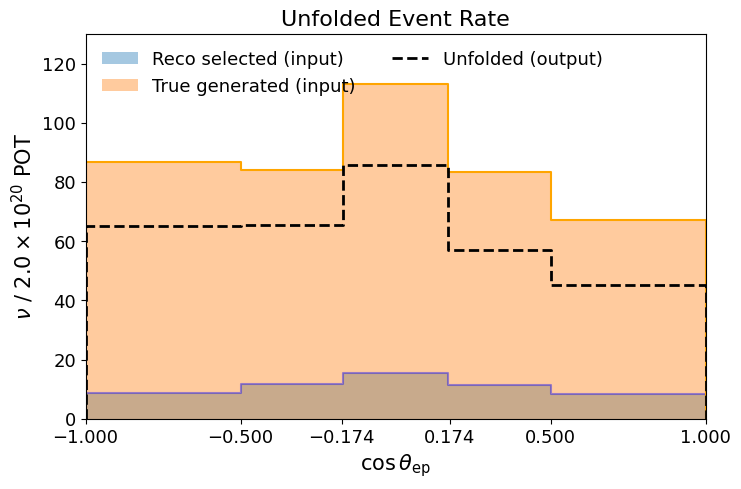

In [23]:

fig = plt.figure(figsize=(8, 5))

plt.step(b_meas+[b_meas[-1]], [0]+list(meas)+[0], alpha=0.4, color='blue')
plt.fill_between(b_meas+[b_meas[-1]],[0]+list(meas)+[0], step="pre", alpha=0.4, label='Reco selected (input)')


plt.step(b_meas+[b_meas[-1]], [0]+list(true)+[0], color='orange')
plt.fill_between(b_meas+[b_meas[-1]],[0]+list(true)+[0], step="pre", alpha=0.4, label='True generated (input)')


plt.step(b_meas+[b_meas[-1]], [0]+unf+[0], color='black', linewidth=2, linestyle='--', label='Unfolded (output)')

plt.legend(fontsize=13)

plt.xlabel(x_label, fontsize=15)

plt.ylabel('$\\nu$ / $2.0 \\times 10^{20}$ POT', fontsize=15)

plt.xlim(bins[0],xhigh)
plt.ylim(0, 130)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=13, loc='upper left', frameon=False, ncol=2)
plt.title('Unfolded Event Rate', fontsize=16)

#if ISRUN3=='': 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/evtrate_"+xvar+"_closuretest.pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [24]:
# covariance of unfolded result (event rate units)

b_unfcov = list(f['unfcov'].edges[0])
unfcov = f['unfcov'].values


Need to convert to xsec units before saving!


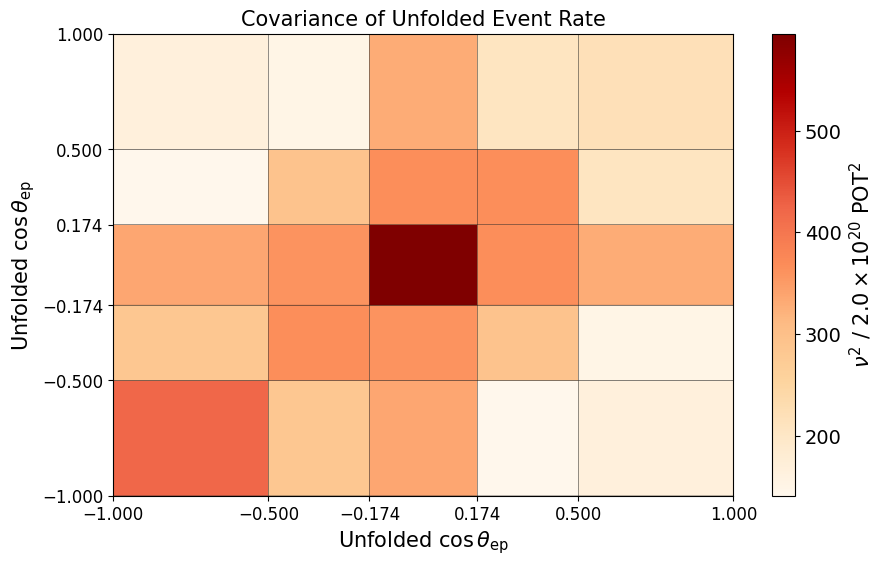

In [25]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(b_unfcov, b_unfcov, unfcov.T, cmap='OrRd', edgecolors='k')#, vmin=1175, vmax=1275)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Unfolded "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

if ISRUN3==False: 
    cbar.set_label(label='$\\nu^{2}$ / $2.0 \\times 10^{20}$ POT$^{2}$', fontsize=15)

plt.title('Covariance of Unfolded Event Rate', fontsize=15)

print("Need to convert to xsec units before saving!")

#if ISRUN3=='' and isData==False: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/cov_evtrate_"+xvar+"_closuretest.pdf", 
#            transparent=True, bbox_inches='tight')

#if isNuWro: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/cov_"+xvar+"_nuwro.pdf", 
#                transparent=True, bbox_inches='tight')


plt.show()

In [26]:
## covariance rotation matrix 

h_covrot = f['covrotation']
covrot = h_covrot.values

# also need the transpose! 
covrot_t = covrot.transpose()

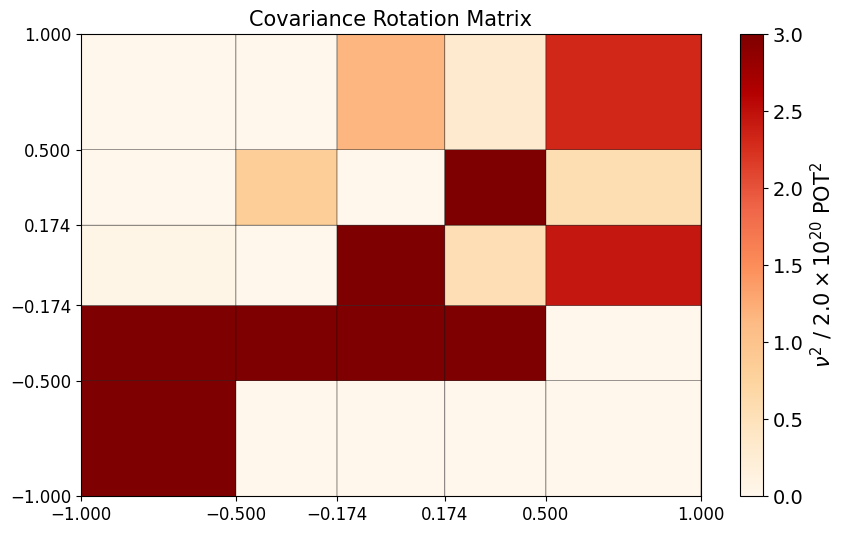

In [27]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(b_unfcov, b_unfcov, covrot.T, cmap='OrRd', edgecolors='k', vmin=0, vmax=3)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

if ISRUN3==False: 
    cbar.set_label(label='$\\nu^{2}$ / $2.0 \\times 10^{20}$ POT$^{2}$', fontsize=15)

plt.title('Covariance Rotation Matrix', fontsize=15)


plt.show()

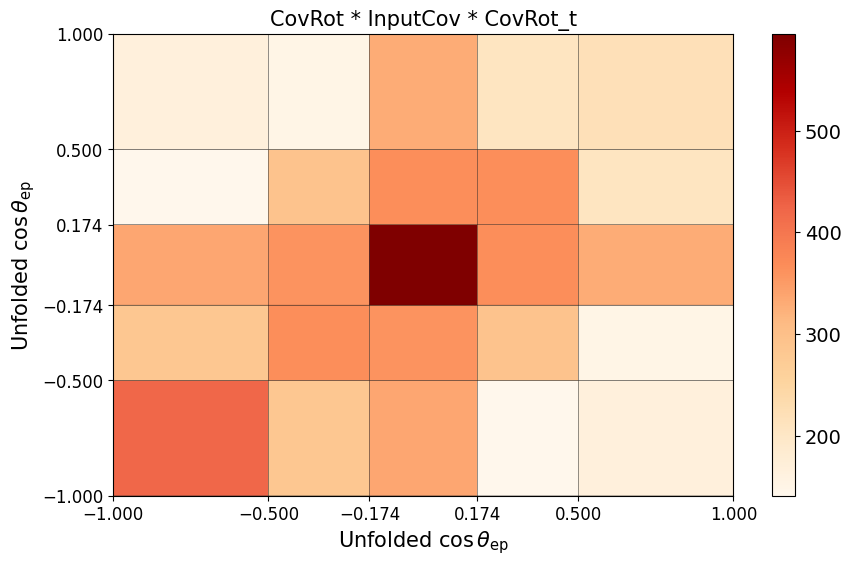

In [28]:
## check: the covariance rotation matrix formula

# rotcov * input cov * rotcov_t

unfcov_check = np.matmul( np.matmul(covrot, cov) , covrot_t)

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(b_unfcov, b_unfcov, unfcov_check.T, cmap='OrRd', edgecolors='k')#, vmin=650, vmax=750)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Unfolded "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

plt.title('CovRot * InputCov * CovRot_t', fontsize=15)

plt.show()

In [29]:
## get the inverse for computation of chi2 
fig = plt.figure(figsize=(10, 6))
inverse_unfcov = np.linalg.inv(unfcov)

<Figure size 1000x600 with 0 Axes>

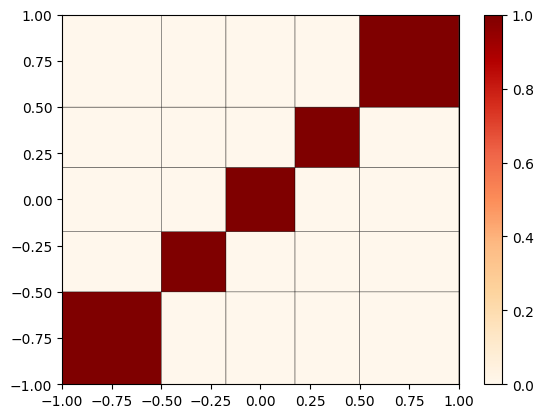

In [30]:
# check 

plt.pcolor(b_unfcov, b_unfcov, np.matmul(unfcov, inverse_unfcov), cmap='OrRd', edgecolors='k', vmin=0)
plt.xlim(xlow,xhigh)
plt.ylim(xlow,xhigh)
cbar = plt.colorbar()
plt.show()

#np.matmul(unfcov, inverse_unfcov)

In [31]:
frac_cov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1): 
    cvi = unf[i]

    for j in range(len(bins)-1):    
        cvj = unf[j]
                
        frac_cov[i][j] = unfcov[i][j]/(cvi*cvj)
        cor[i][j] = unfcov[i][j] / (np.sqrt(unfcov[i][i])*np.sqrt(unfcov[j][j]))

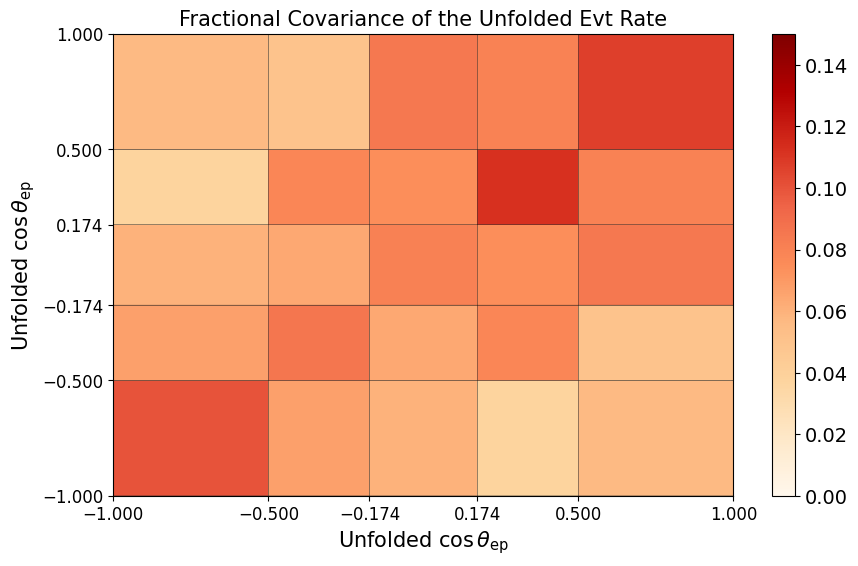

In [32]:
# FRACTIONAL COVARIANCE

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(b_unfcov, b_unfcov, np.array(frac_cov).T, cmap='OrRd', edgecolors='k', vmin=0, vmax=0.15)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Unfolded "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

plt.title('Fractional Covariance of the Unfolded Evt Rate', fontsize=15)

plt.show()

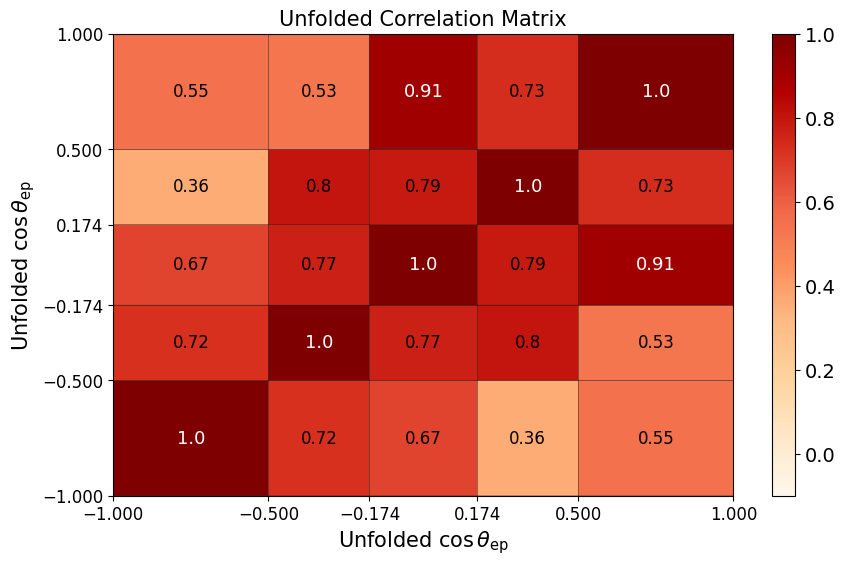

In [33]:
# CORRELATION MATRIX 

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(b_unfcov, b_unfcov, np.array(cor).T, cmap='OrRd', edgecolors='k', vmin=-0.1, vmax=1)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Unfolded "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

text = True

if text: 

    for i in range(len(bins)-1): 
        for j in range(len(bins)-1): 

            if not np.isnan(cor[i][j]): 
                if round(cor[i][j],2)>.8 :
                    plt.text(bincenters[j], bincenters[i], round(cor[i][j], 2), 
                            color='white', ha="center", va="center", fontsize=13)
                else: 
                    plt.text(bincenters[j], bincenters[i], round(cor[i][j], 2), 
                            color='black', ha="center", va="center", fontsize=12)

plt.title('Unfolded Correlation Matrix', fontsize=15)

#if isData: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/cor_"+xvar+"_unblinded.pdf", 
#                transparent=True, bbox_inches='tight')

plt.show()

### Regularization Matrix

In [34]:
# regularization matrix A_c 

h_Ac = f['smear']

In [35]:
b_Ac = list(h_Ac.edges[0])
Ac = h_Ac.values

CHECK that this matches the orientation in ROOT file!
x = true, y = unfolded


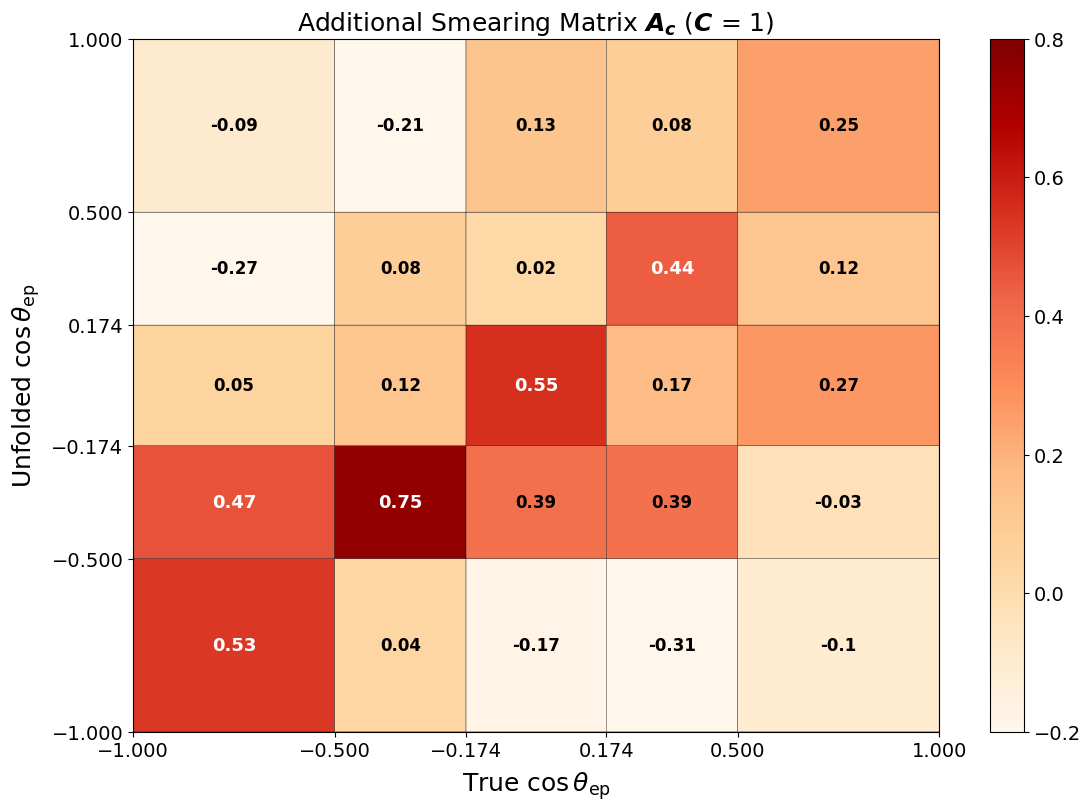

In [36]:
plt.rcdefaults()

fig = plt.figure(figsize=(13, 9))

# pcolor transposes so account for this 

print("CHECK that this matches the orientation in ROOT file!")
print('x = true, y = unfolded')

plt.pcolor(b_Ac, b_Ac, np.array(Ac).T, cmap='OrRd', edgecolors='k', vmin=-0.2, vmax=0.8)
#plt.pcolor(b_Ac, b_Ac, np.array(Ac).T, cmap='OrRd', edgecolors='k', vmin=-0.1, vmax=1)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

#plt.xticks(x_ticks, fontsize=12)
#plt.yticks(x_ticks, fontsize=12)

plt.xticks(x_ticks, fontsize=14)
plt.yticks(x_ticks, fontsize=14)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

# These were originally 15 (to match what was in the paper)
# plt.xlabel("True " + x_label, fontsize=15)
# plt.ylabel("Unfolded " + x_label, fontsize=15)

plt.xlabel("True " + x_label, fontsize=18, labelpad=7)
plt.ylabel("Unfolded " + x_label, fontsize=18, labelpad=7)

plt.title(r'Additional Smearing Matrix $\mathbfit{A_{c}}$ ($\mathbfit{C}$ = '+c+')', fontsize=18)  # (C = '+c+')

text = True

if text: 

    for i in range(len(bins)-1): 
        for j in range(len(bins)-1): 
            
            #print("i = ", i, ", j = ", j, ": Ac[i][j] = ", Ac[i][j])

            if not np.isnan(Ac[i][j]): 
                if round(Ac[i][j],2)>.39 :
                    plt.text(bincenters[i], bincenters[j], round(Ac[i][j], 2), 
                            color='white', ha="center", va="center", fontsize=13, fontweight='bold')
                else: 
                    plt.text(bincenters[i], bincenters[j], round(Ac[i][j], 2), 
                            color='black', ha="center", va="center", fontsize=12, fontweight='bold')


#if ISRUN3=='' and isData==False: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/Ac_"+xvar+"_closuretest.pdf", 
#            transparent=True, bbox_inches='tight')

#if isNuWro: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/Ac_"+xvar+"_nuwro.pdf", 
#                transparent=True, bbox_inches='tight')
    
if isData: 
    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/Ac_"+xvar+"_unblinded_"+c+".pdf", 
    #            transparent=True, bbox_inches='tight')
    #plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/Ac_"+xvar+"_unblinded_text.pdf", 
     # transparent=True, bbox_inches='tight')

    plt.savefig("/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/plots/unfolded/C"+c+"/Smearing_Matrix_"+xvar+"_C"+c+".pdf", transparent=False, bbox_inches='tight')

    #plt.savefig("/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/plots/unfolded/Smearing_Matrix_"+xvar+".pdf", transparent=False, bbox_inches='tight')
    
    plt.show()

## Smear the true distribution by Ac

In [37]:
if isNuWro or (isData==True and ISRUN3==False): 
    # with open('unfolding/variations/FHCVariations_'+xvar+'.json') as f_fhc:
    with open('unfolding/variations/FHCVariations_'+xvar+'_012225.json') as f_fhc:
            fhc_dict = json.load(f_fhc)

# grab the sum of the weights squared -- GENIE
# with open('unfolding/smearing/FHC_'+xvar+'_081323.json') as smearing_fhc:
with open('unfolding/smearing/FHC_'+xvar+'_072024.json') as smearing_fhc:    
            smearing_fhc_dict = json.load(smearing_fhc)

# with open('unfolding/smearing/RHC_'+xvar+'_081323.json') as smearing_rhc:
with open('unfolding/smearing/RHC_'+xvar+'_072024.json') as smearing_rhc:
            smearing_rhc_dict = json.load(smearing_rhc)
        
#genie_gen_sumw2 = np.array(smearing_fhc_dict['true_generated_sumw2']) + np.array(smearing_rhc_dict['true_generated_sumw2'])
    

In [38]:
# check the orientation is correct 
# unf = Ac * R^-1 * meas

# where res^-1 needs to have reco on the x axis 
# so no transpose on res is needed 

np.round( np.matmul( Ac, np.matmul( np.linalg.inv(res), meas ) ), 5) == np.round(unf,5)

# if true, this is how Ac should be used to transform truth histograms

array([ True,  True,  True,  True,  True])

In [39]:
smeared_genie = np.matmul(Ac, true)

print(Ac.shape)
print(true.shape)

fhc_dict['nuwro_generated_signal_ppfx'] = np.array(fhc_dict['nuwro_generated_signal_ppfx'])
print(fhc_dict['nuwro_generated_signal_ppfx'].shape)

if isNuWro or (isData==True and ISRUN3==False):
    smeared_nuwro = np.matmul(Ac, fhc_dict['nuwro_generated_signal_ppfx'])

# if isNuWro or (isData==True and ISRUN3==False): 
#     smeared_nuwro = [np.matmul(Ac, x) for x in fhc_dict['nuwro_generated_signal_ppfx']]
    #s_nuwro = 0 


# compute the smeared bin value 
#for i in range(len(b_Ac)-1):
#    for j in range(len(b_Ac)-1): 
        
        #s_genie = s_genie + np.array(Ac).T[i][j]*true[j] # should be equal to np.matmul(Ac, true)
        #s_genie_gen_sumw2 = s_genie_gen_sumw2 + Ac[i][j]*true[j]
        
#        if isNuWro or (isData==True and ISRUN3==False): 
#            s_nuwro = s_nuwro + Ac[i][j]*fhc_dict['nuwro_generated_signal_ppfx'][j] 

#    smeared_genie.append(s_genie)
#    s_genie = 0
    
    
#    if isNuWro or (isData==True and ISRUN3==False): 
#        smeared_nuwro.append(s_nuwro)
#        s_nuwro = 0
        

(5, 5)
(5,)
(5,)


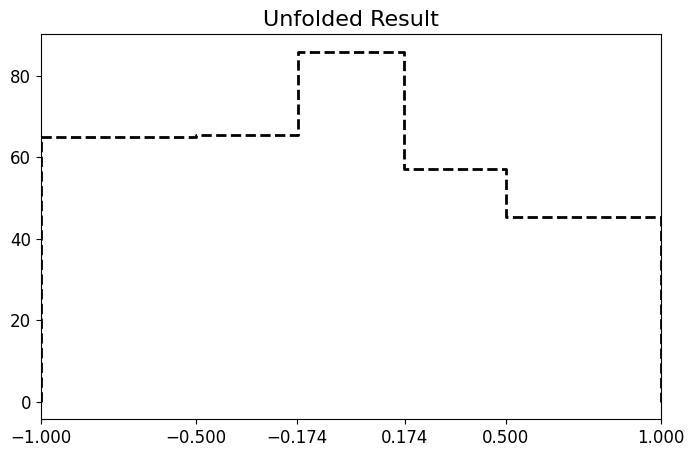

In [40]:
fig = plt.figure(figsize=(8, 5))
   
plt.step(bins+[bins[-1]], [0]+unf+[0], color='black', 
             linewidth=2, linestyle='--', label='unfolded')

plt.xlim(xlow,xhigh)
    
plt.xticks(x_ticks, fontsize=12)
plt.yticks(fontsize=12)


plt.title('Unfolded Result', fontsize=16)
plt.show()

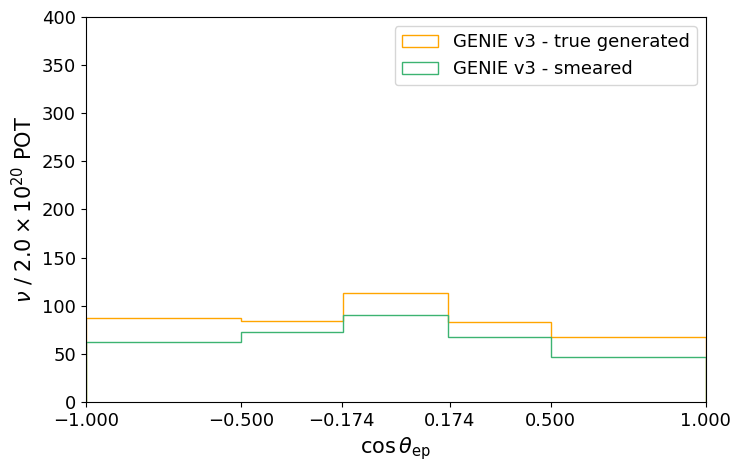

In [41]:
fig = plt.figure(figsize=(8, 5))

 
#plt.fill_between(bins+[bins[-1]],[0]+smeared_genie+[0], step="pre", alpha=0.7, 
#                 label='GENIE v3 true (smeared)', color='mediumseagreen')

#plt.step(bins+[bins[-1]], [0]+smeared_genie+[0], color='mediumseagreen')

plt.hist(bincenters, bins, weights=true,
         color='orange',label='GENIE v3 - true generated', histtype='step')

plt.hist(bincenters, bins, weights=smeared_genie,
         color='mediumseagreen',label='GENIE v3 - smeared', histtype='step')

if isNuWro: 
    plt.fill_between(bins+[bins[-1]],[0]+smeared_nuwro+[0], step="pre", alpha=0.7, 
                 label='NuWro true (smeared)')

    plt.step(bins+[bins[-1]], [0]+smeared_nuwro+[0])
    
#plt.step(bins+[bins[-1]], [0]+unf+[0], color='black', linewidth=2, linestyle='--', label='unfolded')
    
plt.xlim(bins[0],xhigh)
plt.ylim(0, 400)
plt.xticks(x_ticks, fontsize=13)
plt.yticks( fontsize=13)


plt.xlabel(x_label, fontsize=15)

plt.ylabel('$\\nu$ / '+pot, fontsize=15)

plt.legend(fontsize=13)
#plt.title('Smeared Event Rate', fontsize=16)
#plt.savefig(plots_path+"UnfoldedDifferential_VisibleEnergy.pdf", transparent=True, bbox_inches='tight') 


plt.show()

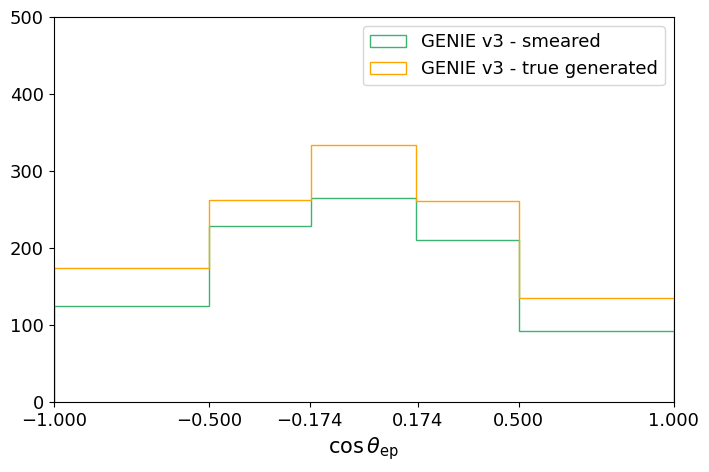

In [42]:
fig = plt.figure(figsize=(8, 5))


plt.hist(bincenters, bins, weights=[x/y for x,y in zip(smeared_genie, binwidth_div)],
         color='mediumseagreen',label='GENIE v3 - smeared', histtype='step')


plt.hist(bincenters, bins, weights=[x/y for x,y in zip(true, binwidth_div)],
         color='orange',label='GENIE v3 - true generated', histtype='step')

if isNuWro: 
    plt.hist(bincenters, bins, weights=[x/y for x,y in zip(smeared_nuwro, binwidth_div)],
         color='blue',alpha=0.3,label='NuWro true (smeared)')
    
#plt.errorbar(bins+[bins[-1]], [0]+[x/y for x,y in zip(unf, binwidth)]+[0], color='black', linewidth=2, label='unfolded')


plt.xlim(bins[0],xhigh)
plt.ylim(0, 500)

plt.xticks(x_ticks, fontsize=13)
plt.yticks( fontsize=13)


plt.xlabel(x_label, fontsize=15)
if xvar != 'tksh_angle': 
    plt.ylabel('$\\nu$ / '+pot+' / GeV', fontsize=15)

plt.legend(fontsize=13)
#plt.title('Smeared Event Rate - Divided by Bin Width', fontsize=16)
#plt.savefig(plots_path+"UnfoldedDifferential_VisibleEnergy.pdf", transparent=True, bbox_inches='tight') 


plt.show()

## Convert to xsec units

In [43]:
# divide by bin width, flux, and n_target 

In [44]:
import selection_functions 
from selection_functions import get_ratio_err

In [45]:
fig = plt.figure(figsize=(8, 7))

###############################################################

h_smeared_genie = plt.hist(bincenters, bins,
                                   weights=1E39*(np.array(smeared_genie)/(n_target*cv_flux*np.array(binwidth_div))))[0]

# smeared nuwro in xsec units
if isNuWro or (isData==True and ISRUN3==False): 
    h_smeared_nuwro = plt.hist(bincenters, bins,
                 weights=1E39*(np.array(smeared_nuwro)/(n_target*cv_flux*np.array(binwidth_div))))[0]

    

plt.close()

###############################################################
# get the sum of the weights squared for this distribution.... how? 
# i lose info about the sumw2 when i smear the distribution (bin-by-bin procedure)



###############################################################
# unfolded result in xsec units

result_xsec = list(1E39*np.array(unf)/(n_target*cv_flux*np.array(binwidth_div)))
y_err = [x*y for x,y in zip(np.sqrt(np.diagonal(frac_cov)), result_xsec)]



In [46]:
# unfolded data covariance - xsec units 
# divide out 1E39 

unfcov_xsec = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
unfcor_xsec = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
Ac_xsec = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

# loop over the bins
for i in range(len(bincenters)): 
    for j in range(len(bincenters)): 
        
        unfcov_xsec[i][j] = unfcov[i][j] / ( (1E-39*n_target*cv_flux*binwidth_div[i]) * (1E-39*n_target*cv_flux*binwidth_div[j]) )
        Ac_xsec[i][j] = Ac[i][j] / ( (1E-39*n_target*cv_flux*binwidth_div[i]) * (1E-39*n_target*cv_flux*binwidth_div[j]) )
        
for i in range(len(bincenters)): 
    for j in range(len(bincenters)): 
        unfcor_xsec[i][j] = unfcov_xsec[i][j] / (np.sqrt(unfcov_xsec[i][i])*np.sqrt(unfcov_xsec[j][j]))



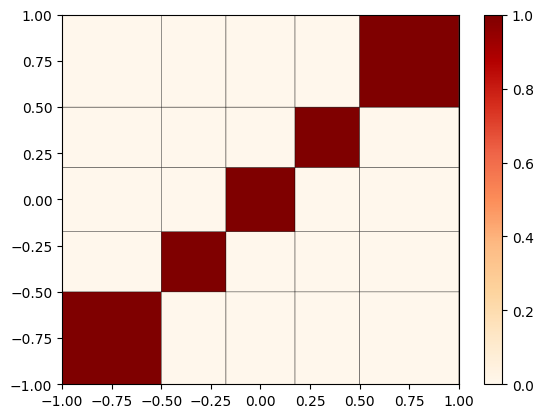

In [47]:
# inverse of unfolded covariance  - xsec units

inverse_unfcov_xsec = np.linalg.inv(unfcov_xsec)

## check 
plt.pcolor(b_unfcov, b_unfcov, np.matmul(unfcov_xsec, inverse_unfcov_xsec), cmap='OrRd', edgecolors='k')
plt.xlim(xlow,xhigh)
plt.ylim(xlow,xhigh)
cbar = plt.colorbar()
plt.show()

# UNFOLDED COVARIANCE MATRIX

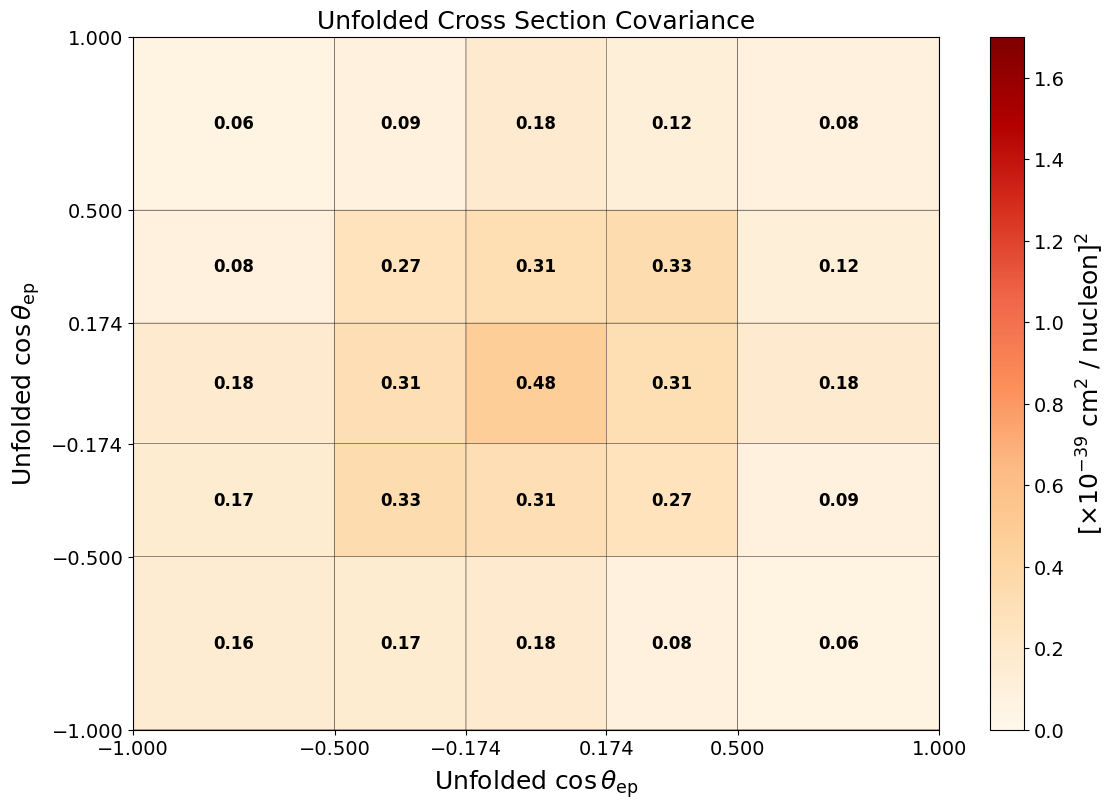

In [48]:
fig = plt.figure(figsize=(13, 9))
        
plt.pcolor(b_unfcov, b_unfcov, np.array(unfcov_xsec).T, cmap='OrRd', edgecolors='k', vmin=0, vmax=1.7)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=18, labelpad=7)
plt.ylabel("Unfolded "+x_label, fontsize=18, labelpad=7)

plt.xticks(x_ticks, fontsize=14)
plt.yticks(x_ticks, fontsize=14)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

if xvar=='tksh_angle': 
    cbar.set_label(label='[$\\times 10^{-39}$ cm$^{2}$ / nucleon]$^{2}$', fontsize=18, labelpad=7)
    
else: 
    cbar.set_label(label='[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]$^{2}$', fontsize=18, labelpad=7)

for i in range(len(bins)-1): 
    for j in range(len(bins)-1): 

        value = np.array(unfcov_xsec).T[j][i]  # Accessing the transposed matrix

        if not np.isnan(value): 
            if value > 1.05:  # Adjust `threshold` based on your visualization needs
                plt.text(bincenters[i], bincenters[j], f'{value:.2f}', 
                         color='white', ha='center', va='center', fontsize=13, fontweight='bold')
            else: 
                plt.text(bincenters[i], bincenters[j], f'{value:.2f}', 
                         color='black', ha='center', va='center', fontsize=12, fontweight='bold')

plt.title('Unfolded Cross Section Covariance', fontsize=18)

#if ISRUN3=='' and isData==False: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/cov_"+xvar+"_closuretest.pdf", 
#            transparent=True, bbox_inches='tight')

#if isNuWro: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/cov_"+xvar+"_nuwro.pdf", 
#                transparent=True, bbox_inches='tight')
    
#if isData: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/cov_"+xvar+"_unblinded.pdf", 
#                transparent=True, bbox_inches='tight')

#plt.savefig("/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/plots/unfolded/Unfolded_Covariance_"+xvar+".pdf", transparent=False, bbox_inches='tight')

plt.show()

In [49]:
# set off diagonals to zero, then take the inverse (for diagonal only chi2)

unfcov_xsec_diag = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1): 
    unfcov_xsec_diag[i][i] = unfcov_xsec[i][i]

inverse_unfcov_xsec_diag = np.linalg.inv(unfcov_xsec_diag)

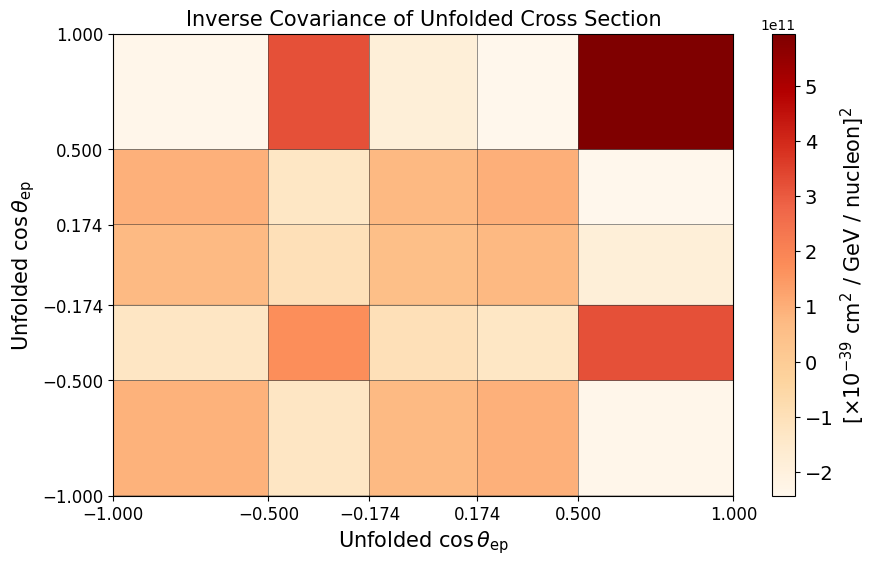

In [50]:
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(b_unfcov, b_unfcov, inverse_unfcov_xsec.T, cmap='OrRd', edgecolors='k')#, vmin=-100000, vmax=100000)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Unfolded "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

cbar.set_label(label='[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]$^{2}$', fontsize=15)

plt.title('Inverse Covariance of Unfolded Cross Section', fontsize=15)

plt.show()

In [51]:
# fractional covariance & correlation (same as event rate plots)  - xsec units 

frac_cov_xsec = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
cor_xsec = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1): 
    cvi = result_xsec[i]

    for j in range(len(bins)-1):    
        cvj = result_xsec[j]
                
        frac_cov_xsec[i][j] = unfcov_xsec[i][j]/(cvi*cvj)
        cor_xsec[i][j] = unfcov_xsec[i][j] / (np.sqrt(unfcov_xsec[i][i])*np.sqrt(unfcov_xsec[j][j]))

In [52]:
################## full chi2 calculation ####################### 

chi2_genie = 0

for i in range(len(bins)-1): 
    
    for j in range(len(h_smeared_genie)): 

            chi2_genie = chi2_genie  + ( (h_smeared_genie[i]-result_xsec[i])*inverse_unfcov_xsec[i][j]*(h_smeared_genie[j]-result_xsec[j]) )
  

if isNuWro or (isData==True and ISRUN3==False): 

    chi2_nuwro = 0 
    
    for i in range(len(h_smeared_nuwro)): 
        for j in range(len(h_smeared_nuwro)): 
            
            chi2_nuwro = chi2_nuwro + ( (h_smeared_nuwro[i] - result_xsec[i])*inverse_unfcov_xsec[i][j]*(h_smeared_nuwro[j] - result_xsec[j]) )
    
    print('nuwro chi2 = ', chi2_nuwro, 'genie chi2 = ', chi2_genie)   
    

nuwro chi2 =  3.4932708740234375 genie chi2 =  1.2792935967445374


IndexError: list index out of range

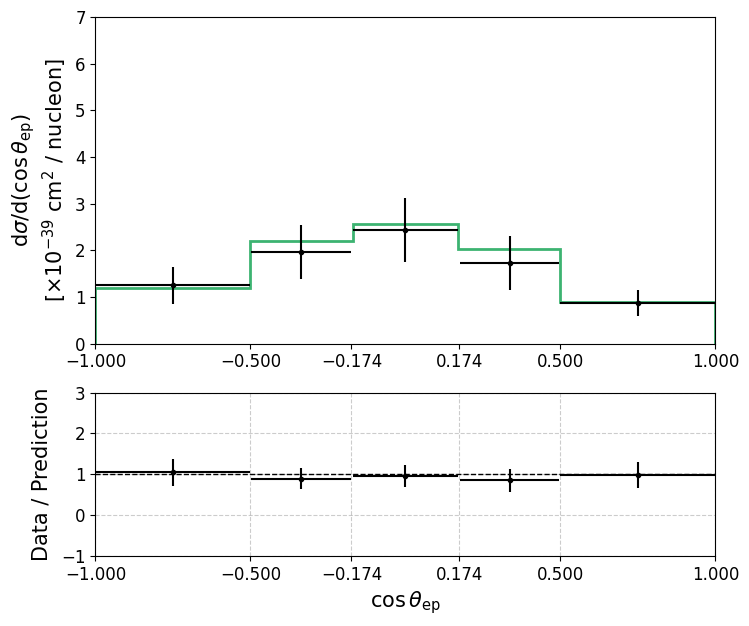

In [53]:
from matplotlib.lines import Line2D

###############################################################

fig = plt.figure(figsize=(8, 7))

gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.tick_params(axis='x', labelsize = 12)#,  rotation=45, )
ax2.tick_params(axis='x', labelsize = 12)#,  rotation=45,)
    
ax1.tick_params(axis = 'y', which = 'major', labelsize = 12)
ax2.tick_params(axis = 'y', which = 'major', labelsize = 12)

#ax1.yaxis.grid(linestyle="--", color='black', alpha=0.2)
#ax1.xaxis.grid(linestyle="--", color='black', alpha=0.2)

ax2.yaxis.grid(linestyle="--", color='black', alpha=0.2)
ax2.xaxis.grid(linestyle="--", color='black', alpha=0.2)

c_label = Line2D([0], [0], color='white', label=f'C = {c}')

###############################################################

if isNuWro: 
    ax1.hist(bincenters, bins, color='dodgerblue', 
                         label='NuWro (smeared)\n$\\chi^{2}$/n = ' + str(round(chi2_nuwro, 1))+'/'+str(len(bincenters)), 
                         range=[bins[0],bins[-1]], histtype='step', 
                         weights=h_smeared_nuwro, alpha=0.5, linewidth=1.5)
    
    ax1.hist(bincenters, bins,  label='GENIE v3 (smeared)\n$\\chi^{2}$/n = ' + str(round(chi2_genie, 1))+'/'+str(len(bincenters)), 
                               range=[bins[0],bins[-1]], 
                               weights=h_smeared_genie, 
                               color='mediumseagreen', histtype='step', 
                               linestyle="--", linewidth=1.5)
    
elif (isData==True and ISRUN3==False): 
    ax1.hist(bincenters, bins,  label='GENIE v3 (smeared)\n$\\chi^{2}$/n = ' + str(round(chi2_genie, 2))+'/'+str(len(bincenters)), 
                               range=[bins[0],bins[-1]], 
                               weights=h_smeared_genie, 
                               color='mediumseagreen',
                               #linestyle="--", 
                               linewidth=2, 
                               histtype='step')
    
###############################################################

else: 
    
    ax1.hist(bincenters, bins, color='#00cc02',
                 label='GENIE v3.0.6 G18 (tuned)\n$\\chi^{2}$/n = ' + str(round(chi2_genie, 1))+'/'+str(len(bincenters)), 
                 range=[bins[0],bins[-1]], 
                     weights=h_smeared_genie,
                 histtype='step')
        

    
###############################################################

# unfolded result

ax1.errorbar(bincenters, result_xsec, 
             xerr=binwidth_plot, yerr=np.abs(y_err), fmt='o', 
             color='black', ecolor='black', markersize=3, label='Data (Stat. + Sys.)') 

###############################################################


# ratio 


if isNuWro==True: 
    ax2.errorbar(bincenters, result_xsec/h_smeared_nuwro, 
                 yerr=np.abs([((a+b)/c)-(a/c) for a,b,c in zip(result_xsec,y_err,h_smeared_nuwro)]), 
                 xerr=binwidth_plot, color="black", fmt='o', markersize=3)
    
else: 
    
    ax2.errorbar(bincenters, result_xsec/h_smeared_genie, 
                 yerr=np.abs([((a+b)/c)-(a/c) for a,b,c in zip(result_xsec,y_err,h_smeared_genie)]), 
                 xerr=binwidth_plot, color="black", fmt='o', markersize=3)

    
############################################

#if xvar=='shr_energy_cali': 
#    ax1.set_ylim(0, 15)
#else: 
ax1.set_ylim(0, 7)
    
ax2.set_ylim(-1, 3)
ax2.set_yticks([-1, 0, 1, 2, 3])

    
if xvar=='tksh_angle':    
    ax1.set_ylabel("d$\\sigma$/d("+x_label+")\n[$\\times 10^{-39}$ cm$^{2}$ / nucleon]", fontsize=15)
    
else: 
    ax1.set_ylabel("d$\\sigma$/d$\\mathit{E}$\n[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]", fontsize=15)

ax1.set_xlim(bins[1],xhigh)
ax1.set_xticks(x_ticks)

ax2.set_xlim(bins[1],xhigh)
ax2.set_xticks(x_ticks)

ax2.set_xlabel(x_label, fontsize=15)
ax2.axhline(1.0, color='black', lw=1, linestyle='--')

if isNuWro==True: 
    ax2.set_ylabel("Unfolded / NuWro", fontsize=15, labelpad=7)
    
else: 
    ax2.set_ylabel("Data / Prediction", fontsize=15, labelpad=7)

 
if xvar=='tksh_angle' and ISRUN3==False: 
    handles, labels = ax1.get_legend_handles_labels()
    order = [0, 2, 1]
    ax1.legend([handles[idx] for idx in order] + [c_label], [labels[idx] for idx in order] + [f'C = {c}'], 
               fontsize=13, loc='upper left', ncol=2, frameon=False) 
    
else: 
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles + [c_label], labels + ["$\mathbfit{C}$ = "+c+""], fontsize=13, frameon=False)

#if xvar=='tksh_angle' and ISRUN3==False: 
    #handles, labels = ax1.get_legend_handles_labels()
    #order = [0,2,1]
    #ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
               #fontsize=13, loc='upper left', ncol=2, frameon=False)

#else: 
    #ax1.legend(fontsize=13, frameon=False)

#if ISRUN3=='': 
    #ax1.set_title('MicroBooNE NuMI Data: $7.0 \\times 10^{20}$ POT', fontsize=16)
    
#elif ISRUN3==False: 
    #ax1.set_title('FHC Cross Section', fontsize=16)
    
#elif ISRUN3==True: 
    #ax1.set_title('RHC Cross Section', fontsize=16)
    

############################################################

#if ISRUN3=='' and isData==False: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/combined_"+xvar+"_closuretest.pdf", 
#            transparent=True, bbox_inches='tight')

#if isNuWro: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/result_"+xvar+"_nuwro.pdf", 
#                transparent=True, bbox_inches='tight')
    
#if isData: 
#    plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/result_"+xvar+"_unblinded_"+c+".pdf", 
#                transparent=True, bbox_inches='tight')

# Add the text to the axes with a newline character
ax1.text(0.03, 0.83, "MicroBooNE FHC+RHC:\n$7.0\\times10^{20}$ POT",
         fontsize=13.5, transform=ax1.transAxes, horizontalalignment='left')

#plt.savefig("/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/plots/unfolded/C"+c+"/result_"+xvar+"_C"+c+".pdf", transparent=False, bbox_inches='tight')

plt.show()

result_xsec_rounded = np.round(result_xsec, 2)

print("Cross-Section Values:", result_xsec_rounded)

In [ ]:
c

In [ ]:
fig = plt.figure(figsize=(8, 5))  

plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diagonal(frac_cov)), color='black', 
        linewidth=2)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)


plt.title("Fractional Uncertainty", fontsize=16)
plt.grid(linestyle=":")
plt.show()



## Generator Comparisons

In [80]:
# path = "/exp/uboone/app/users/kmiller/BuildEventGenerators/FlatTreeAnalyzer/OutputFiles/" 
path = "/Users/abarnard/phd/ccnp/generator_samples/"

f_neut_gen = uproot.open(path+"FlatTreeAnalyzerOutput_NEUT.root")
f_nuwro_gen = uproot.open(path+"FlatTreeAnalyzerOutput_NuWro.root")
f_genie_gen = uproot.open(path+"FlatTreeAnalyzerOutput_GENIE_SBN.root")
f_gibuu_gen = uproot.open(path+"FlatTreeAnalyzerOutput_GiBUU.root")
f_genieextra_gen = uproot.open((path+"FlatTreeAnalyzerOutput_GENIE_uB.root"))


In [81]:
# convert back to event rate units for Ac smearing 

if true_var == 'true_e_visible2': 
    gen_var = 'true_e_visible'
    
else: 
    # gen_var = true_var # Default?
    gen_var = 'elec_ke' 
    # gen_var = 'opening_angle'

gen_dict = {   
    'NEUT' : {'true' : (f_neut_gen[gen_var].values/1E39) * (n_target*cv_flux*np.array(binwidth_div)), 'smeared' : []},
    'GENIE' : {'true' : (f_genie_gen[gen_var].values/1E39) * (n_target*cv_flux*np.array(binwidth_div)), 'smeared' : []},
    'NuWro' : {'true' : (f_nuwro_gen[gen_var].values/1E39) * (n_target*cv_flux*np.array(binwidth_div)), 'smeared' : []}, 
    'GiBUU' : {'true' : (f_gibuu_gen[gen_var].values/1E39) * (n_target*cv_flux*np.array(binwidth_div)), 'smeared' : []},
    'GENIEExtra' : {'true' : (f_genieextra_gen[gen_var].values/1E39) * (n_target*cv_flux*np.array(binwidth_div)), 'smeared' : []},
    'GENIE_cv' : {'true' : true, 'smeared' : []}
}


In [ ]:
# check correct Ac matrix orientation 
np.round( np.matmul( Ac, np.matmul( np.linalg.inv(res), meas ) ), 5) == np.round(unf,5)

In [83]:
# smear the event generators -- in event rate units

for key in gen_dict: 
    gen_dict[key]['smeared'] = np.matmul(Ac, gen_dict[key]['true'])


#for key in gen_dict: # where key is the generator name in a dictionary 
    
#    for i in range(len(b_Ac)-1): # where i is the row of matrix Ac
#        s = 0
        
#        for j in range(len(b_Ac)-1): # where j is the column of matrix Ac
            
#            s = s + ( Ac[i][j] * gen_dict[key]['true'][j] ) # equal to np.matmul(Ac, gen_dict['GENIE']['true'])
            
            #if key == 'GENIE': 
            #    print("i = ", i, ", j = ", j, ": ", Ac[i][j], " * ", gen_dict[key]['true'][j], " = ", Ac[i][j] * gen_dict[key]['true'][j])
            
#        gen_dict[key]['smeared'].append(s)

In [84]:
# convert back to xsec units 

for key in gen_dict:
    gen_dict[key]['true'] = (gen_dict[key]['true']*1E39) / (n_target*cv_flux*np.array(binwidth_div))
    gen_dict[key]['smeared'] = (np.array(gen_dict[key]['smeared'])*1E39) / (n_target*cv_flux*np.array(binwidth_div))

In [ ]:
# compute the chi2 

for key in gen_dict:
    chi2 = 0
    
    for i in range(len(bins)-1): 
        for j in range(len(result_xsec)): 
            chi2 = chi2 + ( (gen_dict[key]['smeared'][i]-result_xsec[i])*inverse_unfcov_xsec[i][j]*(gen_dict[key]['smeared'][j]-result_xsec[j]) )
    
    gen_dict[key]['chi2'] = chi2
    

In [ ]:
gen_dict

In [196]:
import matplotlib.lines as mlines

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(bincenters, bins, weights=gen_dict['NEUT']['smeared'], histtype='step', color='#ffc161', linewidth=1)
neut_line = mlines.Line2D([], [], color='#ffc161',
                          label='NEUT v5.4.0\n$\\chi^{2}$/n = ' + str(round(gen_dict['NEUT']['chi2'], 1)) + '/' + str(len(bincenters)))

ax.hist(bincenters, bins, weights=gen_dict['GiBUU']['smeared'], histtype='step', linewidth=1, color='#a393eb')
gibuu_line = mlines.Line2D([], [], color='#a393eb',
                           label='GiBUU 2023\n$\\chi^{2}$/n = ' + str(round(gen_dict['GiBUU']['chi2'], 1)) + '/' + str(len(bincenters)))

ax.hist(bincenters, bins, weights=gen_dict['GENIE']['smeared'], histtype='step', linewidth=1, color='#ff0000')
genie_line = mlines.Line2D([], [], color='#ff0000',
                           label='GENIE v3.4.0 AR23\n$\\chi^{2}$/n = ' + str(round(gen_dict['GENIE']['chi2'], 1)) + '/' + str(len(bincenters)))

ax.hist(bincenters, bins, weights=gen_dict['GENIE_cv']['smeared'], histtype='step', linewidth=1, color='#00cc02')
geniecv_line = mlines.Line2D([], [], color='#00cc02',
                           label='GENIE v3.0.6 G18 (tuned)\n$\\chi^{2}$/n = ' + str(round(gen_dict['GENIE_cv']['chi2'], 1)) + '/' + str(len(bincenters)))

ax.hist(bincenters, bins, weights=gen_dict['NuWro']['smeared'], histtype='step', linewidth = 1.3, color = 'dodgerblue') #linewidth=1.3, color='dodgerblue', linestyle='dashdot')
nuwro_line = mlines.Line2D([], [], color='dodgerblue',
                           label='NuWro v21.09.2\n$\\chi^{2}$/n = ' + str(round(gen_dict['NuWro']['chi2'], 1)) + '/' + str(len(bincenters)))

data = ax.errorbar(bincenters, result_xsec, xerr=binwidth_plot, yerr=y_err, fmt='o', color='black', ecolor='black', markersize=3,
                   label='NuMI Data\n(Stat. + Sys.)', linewidth=2)

ax.set_ylim(0, 7.4)
ax.set_xlim(bins[0], xhigh)


ax.set_xticks(x_ticks)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.tick_params(axis='x', labelsize=12) # Originally both 11
ax.tick_params(axis='y', labelsize=12)


ax.set_xlabel(x_label, fontsize=15, labelpad=7)

if xvar == 'tksh_angle':
    ax.set_ylabel("d$\\sigma$/d(" + x_label + ")\n[$\\times 10^{-39}$ cm$^{2}$ / nucleon]", fontsize=15, labelpad=7)
else:
    ax.set_ylabel("d$\\sigma$/d$\\mathit{E}$\n[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]", fontsize=15, labelpad=7)

leg = ax.legend(fontsize=10, frameon=False, ncol=1, loc='upper right',
                handles=[neut_line, nuwro_line, gibuu_line, genie_line, geniecv_line, data])

for legobj in leg.legend_handles:
    legobj.set_linewidth(2.2)

#ax.text(0.97, 0.61, "MicroBooNE FHC+RHC:\n$7.0\\times10^{20}$ POT",
        #fontsize=13.5, transform=ax.transAxes, horizontalalignment='right')

#ax.text(0.025, 0.87, "MicroBooNE FHC+RHC: $7.0\\times10^{20}$ POT \nIn Progress",
        #fontsize=12, transform=ax.transAxes, horizontalalignment='left')

ax.text(0.025, 0.861, "MicroBooNE FHC+RHC:\n$7.0\\times10^{20}$ POT",
        fontsize=13.5, transform=ax.transAxes, horizontalalignment='left')

#ax.text(0.025, 0.915, "MicroBooNE FHC: $2.0\\times10^{20}$ POT",
        #fontsize=13.5, transform=ax.transAxes, horizontalalignment='left')

#ax.text(0.025, 0.915, "MicroBooNE RHC: $5.0\\times10^{20}$ POT",
        #fontsize=13.5, transform=ax.transAxes, horizontalalignment='left')

# Save the figure
#plt.savefig("/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/plots/unfolded/result_"+xvar+".pdf", transparent=False, bbox_inches='tight')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(bincenters, bins, weights=gen_dict['NEUT']['true'], histtype='step', color='#ffc161', linewidth=1)
neut_line = mlines.Line2D([], [], color='#ffc161',
                          label='NEUT v5.4.0\n$\\chi^{2}$/n = ' + str(round(gen_dict['NEUT']['chi2'], 1)) + '/' + str(len(bincenters)))

ax.hist(bincenters, bins, weights=gen_dict['GiBUU']['true'], histtype='step', linewidth=1, color='#a393eb')
gibuu_line = mlines.Line2D([], [], color='#a393eb',
                           label='GiBUU 2023\n$\\chi^{2}$/n = ' + str(round(gen_dict['GiBUU']['chi2'], 1)) + '/' + str(len(bincenters)))

ax.hist(bincenters, bins, weights=gen_dict['GENIE']['true'], histtype='step', linewidth=1, color='#ff0000')
genie_line = mlines.Line2D([], [], color='#ff0000',
                           label='GENIE v3.4.0 AR23\n$\\chi^{2}$/n = ' + str(round(gen_dict['GENIE']['chi2'], 1)) + '/' + str(len(bincenters)))

ax.hist(bincenters, bins, weights=gen_dict['GENIE_cv']['true'], histtype='step', linewidth=1, color='#00cc02')
geniecv_line = mlines.Line2D([], [], color='#00cc02',
                           label='GENIE v3.0.6 G18 (tuned)\n$\\chi^{2}$/n = ' + str(round(gen_dict['GENIE_cv']['chi2'], 1)) + '/' + str(len(bincenters)))

ax.hist(bincenters, bins, weights=gen_dict['NuWro']['true'], histtype='step', linewidth = 1.3, color = 'dodgerblue') #linewidth=1.3, color='dodgerblue', linestyle='dashdot')
nuwro_line = mlines.Line2D([], [], color='dodgerblue',
                           label='NuWro v21.09.2\n$\\chi^{2}$/n = ' + str(round(gen_dict['NuWro']['chi2'], 1)) + '/' + str(len(bincenters)))

data = ax.errorbar(bincenters, result_xsec, xerr=binwidth_plot, yerr=y_err, fmt='o', color='black', ecolor='black', markersize=3,
                   label='NuMI Data\n(Stat. + Sys.)', linewidth=2)

ax.set_ylim(0, 7.4)
ax.set_xlim(bins[0], xhigh)


ax.set_xticks(x_ticks)
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.tick_params(axis='x', labelsize=12) # Originally both 11
ax.tick_params(axis='y', labelsize=12)


ax.set_xlabel(x_label, fontsize=15, labelpad=7)

if xvar == 'tksh_angle':
    ax.set_ylabel("d$\\sigma$/d(" + x_label + ")\n[$\\times 10^{-39}$ cm$^{2}$ / nucleon]", fontsize=15, labelpad=7)
else:
    ax.set_ylabel("d$\\sigma$/d$\\mathit{E}$\n[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]", fontsize=15, labelpad=7)

leg = ax.legend(fontsize=10, frameon=False, ncol=1, loc='upper right',
                handles=[neut_line, nuwro_line, gibuu_line, genie_line, geniecv_line, data])

for legobj in leg.legend_handles:
    legobj.set_linewidth(2.2)

#ax.text(0.97, 0.61, "MicroBooNE FHC+RHC:\n$7.0\\times10^{20}$ POT",
        #fontsize=13.5, transform=ax.transAxes, horizontalalignment='right')

#ax.text(0.025, 0.87, "MicroBooNE FHC+RHC: $7.0\\times10^{20}$ POT \nIn Progress",
        #fontsize=12, transform=ax.transAxes, horizontalalignment='left')

ax.text(0.025, 0.861, "MicroBooNE FHC+RHC:\n$7.0\\times10^{20}$ POT",
        fontsize=13.5, transform=ax.transAxes, horizontalalignment='left')

#ax.text(0.025, 0.915, "MicroBooNE FHC: $2.0\\times10^{20}$ POT",
        #fontsize=13.5, transform=ax.transAxes, horizontalalignment='left')

#ax.text(0.025, 0.915, "MicroBooNE RHC: $5.0\\times10^{20}$ POT",
        #fontsize=13.5, transform=ax.transAxes, horizontalalignment='left')

# Save the figure
#plt.savefig("/Users/abarnard/phd/ccnp/uBNuMI_CC1eNp/plots/unfolded/result_"+xvar+"_True.pdf", transparent=False, bbox_inches='tight')

plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 5))

x = plt.hist(bincenters, bins, weights=gen_dict['GENIE']['smeared'], histtype='step', linewidth=1, color='#ff0000')
genie_line = mlines.Line2D([], [], color='#ff0000' , 
        label='GENIE v3.0.6 (untuned)\n$\\chi^{2}$/n = ' + str(round(gen_dict['GENIE']['chi2'], 1))+'/'+str(len(bincenters)))

plt.hist(bincenters, bins, weights=gen_dict['GENIE_cv']['smeared'], histtype='step', linewidth=1, color='#00cc02')
geniecv_line = mlines.Line2D([], [], color='#00cc02', 
        label='GENIE v3.0.6 (tuned)\n$\\chi^{2}$/n = ' + str(round(gen_dict['GENIE_cv']['chi2'], 1))+'/'+str(len(bincenters)))


data = plt.errorbar(bincenters, result_xsec, 
             xerr=binwidth_plot, yerr=y_err, fmt='o', 
             color='black', ecolor='black', markersize=3, label='Data (Stat. + Sys.)',linewidth=2) 
       
    
plt.xlim(bins[0],xhigh)
#plt.ylim(0, 8)
plt.ylim(0, 8.308856211870095) 

plt.xticks(x_ticks, fontsize=11)
plt.yticks(fontsize=11)


plt.xlabel(x_label, fontsize=16, labelpad=8)

if xvar=='tksh_angle':    
    plt.ylabel("d$\\sigma$/d("+x_label+")\n[$\\times 10^{-39}$ cm$^{2}$ / nucleon]", fontsize=16, labelpad=8)
    
else: 
    plt.ylabel("d$\\sigma$/dE\n[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]", fontsize=16, labelpad=8)


leg = plt.legend(fontsize=12.5, frameon=False, ncol=1, loc='upper right', 
                 handles=[ 
                          genie_line, geniecv_line, 
                     data])

for legobj in leg.legend_handles:
    legobj.set_linewidth(2.2)

import pickle

#plot_data_old = {'x': bincenters, 'y': result_xsec, 'x_err': binwidth_plot, 'y_err': y_err}
#with open('plot_data_old.pkl', 'wb') as f:
    #pickle.dump(plot_data_old, f)


#plt.savefig("/exp/uboone/app/users/abarnard/plots/XSEC_"+xvar+"_New.pdf", transparent=False, bbox_inches='tight', dpi=1000)
#plt.savefig("/exp/uboone/app/users/abarnard/plots/New_Unfolded_Data_Only.pdf", transparent=False, bbox_inches='tight', dpi=1000)

plt.show()


## Comparrisson Plots

### save to file

In [200]:
gen_path = "/exp/uboone/app/users/abarnard/katrina_analysis/code/uBNuMI_CC1eNp/unfolding/generator_comparisons"

In [ ]:
import os 
from datetime import date

filename = gen_var+"_generator_comparisons_nopeak_"+date.today().strftime("%m%d%y")+".root"
    
if os.path.exists(gen_path+filename): 
    print(gen_path+filename, "exists and is readable, need to update file name to save ! ")
    
else: 
    
    f_gen = ROOT.TFile.Open(gen_path+filename, "NEW")
    
    ####### generator comparisons (smeared) #######
    for key in gen_dict.keys(): 

        smeared_root = TH1F(key+"_"+gen_var, key+" Cross Section Prediction (Smeared)", len(bincenters), np.array(bins))
        unsmeared_root = TH1F(key+"_"+gen_var+"_unsmeared", key+" Cross Section Prediction (Unsmeared)", len(bincenters), np.array(bins))

        for i in range(len(bincenters)): 
            smeared_root.Fill(bincenters[i], gen_dict[key]['smeared'][i])
            unsmeared_root.Fill(bincenters[i], gen_dict[key]['true'][i])
        
        f_gen.cd()
        smeared_root.Write()
        smeared_root.Reset()
        
        unsmeared_root.Write()
        unsmeared_root.Reset()

    ####### Ac matrix #####################
    Ac_root = TH2D("Ac_"+gen_var, "Ac - Additional Smearing Matrix (Event Rate Units)", 
                   len(bincenters), np.array(bins), len(bincenters), np.array(bins))

    for i in range(len(bincenters)): 
        for j in range(len(bincenters)): 

            Ac_root.Fill(bincenters[i], bincenters[j], Ac[i][j])
            
    f_gen.cd()
    Ac_root.Write()
    
    ####### unfolded result (xsec units) #####################
    
    unf_root = TH1F("unf_xsec_"+gen_var, "Unfolded NuMI Data Result (Cross Section Units)", len(bincenters), np.array(bins))

    for i in range(len(bincenters)): 
        unf_root.Fill(bincenters[i], result_xsec[i])
    
    unfcov_root = TH2D("unfcov_xsec_"+gen_var, "Unfolded Covariance of NuMI Data Result (Cross Section Units)", 
                       len(bincenters), np.array(bins), len(bincenters), np.array(bins))

    for i in range(len(bincenters)): 
        for j in range(len(bincenters)): 

            unfcov_root.Fill(bincenters[j], bincenters[i], unfcov_xsec[i][j])
            
    f_gen.cd()
    unf_root.Write()
    unfcov_root.Write()
    
    f_gen.Close()
 

In [ ]:
print(true_var)
print('\nchi2 -- full :')

for key in gen_dict:
    chi2 = 0
    
    for i in range(len(bincenters)): 
        for j in range(len(bincenters)): 
            chi2 = chi2 + ( (gen_dict[key]['smeared'][i]-result_xsec[i])*inverse_unfcov_xsec[i][j]*(gen_dict[key]['smeared'][j]-result_xsec[j]) )
    
    print(key, round(chi2,1), '(chi2 = '+str(round(chi2,1))+'/'+str(len(bincenters))+')')

## p-value calculation

In [ ]:
from scipy.stats import chi2, norm

chi_squared = 12.8
degrees_of_freedom = 1
p_value = 1 - chi2.cdf(chi_squared, degrees_of_freedom)

sigma = norm.ppf(1 - p_value / 2)

# Print results
print(f"P-value: {round(p_value, 5)}")
print(f"Sigma: {round(sigma, 1)}")

In [ ]:
# Delete everything but the first bin (keep index 0)
inv = np.delete(unfcov_xsec, obj=[i for i in range(len(bincenters)) if i != 0], axis=0)
inv = np.linalg.inv(np.delete(inv, obj=[i for i in range(len(bincenters)) if i != 0], axis=1))

print('chi2 -- first bin ONLY:')
for key in gen_dict:
    chi2 = 0
    # Calculate the difference for the first bin
    delta = gen_dict[key]['smeared'][0] - result_xsec[0]
    # Compute chi-squared for the first bin
    chi2 = delta**2 * inv[0, 0]
    print(key, round(chi2, 1), f'(chi2 = {round(chi2, 1)}/1)')

In [ ]:
# make a new inverse matrix to use -- delete everything but the first two bins 
inv = np.delete(unfcov_xsec, obj=[i for i in range(len(bincenters)) if i>1], axis=0)
inv = np.linalg.inv(np.delete(inv, obj=[i for i in range(len(bincenters)) if i>1], axis=1))
    
   
print('chi2 -- first two bins ONLY :')
for key in gen_dict:
    chi2 = 0
    
    for i in range(len(inv)): 
        for j in range(len(inv)): 
            chi2 = chi2 + ( (gen_dict[key]['smeared'][i]-result_xsec[i])*inv[i][j]*(gen_dict[key]['smeared'][j]-result_xsec[j]) )
    print(key, round(chi2,1), '(chi2 = '+str(round(chi2,1))+'/'+str(len(inv))+')')
    

In [ ]:
inv = np.delete(unfcov_xsec, obj=[0, 1], axis=0)
inv = np.linalg.inv( np.delete(inv, obj=[0, 1], axis=1) )
 
print('chi2 -- excluding first two bins:')
for key in gen_dict:
    chi2 = 0
    
    for i in range(len(inv)): 
        for j in range(len(inv)): 
            chi2 = chi2 + ( (gen_dict[key]['smeared'][i+2]-result_xsec[i+2])*inv[i][j]*(gen_dict[key]['smeared'][j+2]-result_xsec[j+2]) )
    
    print(key, round(chi2,1), '(chi2 = '+str(round(chi2,1))+'/'+str(len(inv))+')')
    
    

## EXTRA/OUTDATED

### Uncorrelated uncertainites - GENIE vs. NuWro

In [ ]:
#with open('unfolding/covariance/closuretests/'+xvar+'_FHC_abs_inputcov_ClosureTest.json') as f_genie:
#    inputcov_genie_dict = json.load(f_genie)

In [ ]:
recreate = False

In [ ]:
if isNuWro: 
    
    print('opening NuWro input covariances....')

    with open('unfolding/covariance/fakedata/'+xvar+'_FHC_abs_inputcov_NuWro.json') as f:
        inputcov_dict = json.load(f)
        
else: 
    
    print('opening GENIE input covariances....')

    with open('unfolding/covariance/closuretests/'+xvar+'_FHC_abs_inputcov_ClosureTest.json') as f:
        inputcov_dict = json.load(f)
    
    

In [ ]:
# rotate the input covariances - this is in event rate units

# statistical 
fhc_statcov = np.array(inputcov_dict['response_matrix']) + np.array(inputcov_dict['stat'])
rot_input_statcov = np.matmul( np.matmul(covrot, fhc_statcov), covrot_t )

# genie 
fhc_geniecov  = np.array(inputcov_dict['genie_ms']) + np.array(inputcov_dict['genie_us'])
rot_input_geniecov = np.matmul( np.matmul(covrot, fhc_geniecov), covrot_t ) 

# frac cov
frac_statcov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]
frac_geniecov =  [ [0]*(len(bins)-1) for x in range(len(bins)-1) ]

for i in range(len(bins)-1): 
    cvi = unf[i]
    
    for j in range(len(bins)-1):    
        cvj = unf[j]
                
        frac_statcov[i][j] = fhc_statcov[i][j]/(cvi*cvj)
        frac_geniecov[i][j] = fhc_geniecov[i][j]/(cvi*cvj)


# convert to fractional uncertainty 
unf_uncor_fraccov_xsec = np.array(frac_statcov) + np.array(frac_geniecov)


In [ ]:
fhc_statcov

In [ ]:
# plot the result with uncorrelated uncertainties only 

fig = plt.figure(figsize=(8, 5))
    
#plt.errorbar(bincenters, result_xsec, xerr=binwidth, 
#             yerr=y_err, 
#             fmt='o', 
#             color='black', ecolor='black', markersize=3, label='Total') 

y_err_uncor = [x*y for x,y in zip(np.sqrt(np.diagonal(unf_uncor_fraccov_xsec)), result_xsec)]
             
plt.errorbar(bincenters, result_xsec, xerr=binwidth_plot, 
             yerr=y_err_uncor, 
             fmt='o', 
             color='turquoise', ecolor='turquoise', markersize=3, label='Uncorrelated') 

plt.xlim(bins[0],xhigh)
plt.ylim(0, 12)

plt.xticks(x_ticks, fontsize=13)
plt.yticks( fontsize=13)


plt.xlabel(x_label, fontsize=15)
if xvar != 'tksh_angle': 
    plt.ylabel('$\\nu$ / '+pot+' / GeV', fontsize=15)

plt.legend(fontsize=13)

if isNuWro: 
    plt.title('NuWro', fontsize=16)
    
else: 
    plt.title("GENIE", fontsize=16)


plt.show()

# save 

### Breakdown of unfolded covariance - beam on

In [ ]:
# rotate through covRot matrix 
# plot the fractional uncertainty & compare the input vs. output distributions 

In [ ]:
# get the input covariances 

if isData: 
    with open('unfolding/covariance/beamon/'+xvar+'_Combined_abs_inputcov_BeamOn.json') as f:
            inputcov_dict = json.load(f)

In [ ]:
inputcov_dict.keys()

In [ ]:
# rotate the total input covariance  - this is in event rate units

rot_input_totcov = np.matmul( np.matmul(covrot, inputcov_dict['total']), covrot_t )

fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, rot_input_totcov, cmap='OrRd', edgecolors='k')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Unfolded "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

cbar.set_label(label='$\\nu^{2}$ / $7.0 \\times 10^{20}$ POT$^{2}$', fontsize=15)

plt.title('CovRot * InputCov * CovRot_t', fontsize=15)

plt.show()



In [ ]:
# fractional covariance 

rot_input_fraccov = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 

for i in range(len(bins)-1):
    for j in range(len(bins)-1): 
        rot_input_fraccov[i][j] = rot_input_totcov[i][j]/(unf[i]*unf[j])
        
fig = plt.figure(figsize=(10, 6))
        
plt.pcolor(bins, bins, rot_input_fraccov, cmap='OrRd', edgecolors='k',  vmin=0, vmax=0.15)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Unfolded "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

plt.title('Fractional Covariance', fontsize=15)

plt.show()



In [ ]:
# fractional uncertainty - compare to automated output 


fig = plt.figure(figsize=(8, 5))  

plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diag(frac_cov)), color='black', 
        linewidth=2, label='WSVD output')

plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diagonal(rot_input_fraccov)), color='cornflowerblue', 
        linewidth=2, linestyle='--', label='Rotated output')

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.5)

plt.legend(fontsize=14)

plt.title("Fractional Uncertainty", fontsize=16)
plt.grid(linestyle=":")
plt.show()

In [ ]:
output_cov = {}
output_fraccov = {}
output_frac = {}
output_cor = {}

In [ ]:
# for source in inputcov_dict
# compute the rotation output covariance 
# compute the fractional covariance 
# compute the fractional uncertainty 

for key in inputcov_dict.keys(): 
    
    # absolute covariance - event rate units
    output_cov[key] = np.matmul( np.matmul(covrot, inputcov_dict[key]), covrot_t )
    
    # fractional covariance
    output_fraccov[key] = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 
    output_cor[key] = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 

    
    for i in range(len(bins)-1):
        for j in range(len(bins)-1): 
            
            # convert to xsec units 
            output_cov[key][i][j] = output_cov[key][i][j] / ( (1E-39*n_target*cv_flux*binwidth_div[i]) * (1E-39*n_target*cv_flux*binwidth_div[j]) )
            
            output_fraccov[key][i][j] = output_cov[key][i][j]/(result_xsec[i]*result_xsec[j])
            output_cor[key][i][j] = output_cov[key][i][j]/(np.sqrt(output_cov[key][i][i])*np.sqrt(output_cov[key][j][j]))
            
    # fractional uncertainty 
    output_frac[key] = np.sqrt(np.diagonal(output_fraccov[key]))
    
    
    

In [ ]:
# combine flux, genie, stat curves for fractional uncertainty plot 

output_frac['flux_all'] = np.sqrt(np.diagonal([ [x+y for x,y in zip(a,b)] for a,b in zip(output_fraccov['ppfx'], output_fraccov['beamline'])]))
output_frac['genie_all'] = np.sqrt(np.diagonal([ [x+y for x,y in zip(a,b)] for a,b in zip(output_fraccov['genie_ms'], output_fraccov['genie_us'])]))
output_frac['stat_all'] = np.sqrt(np.diagonal([ [x+y for x,y in zip(a,b)] for a,b in zip(output_fraccov['response_matrix'], output_fraccov['stat'])]))



In [ ]:
fig = plt.figure(figsize=(8, 5))  

# TOTAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Total",
            weights=output_frac['total'], linewidth=2, color='black')

# FLUX
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Flux", 
             weights=output_frac['flux_all'])#, color='royalblue')

# CROSS SECTION MODELS 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GENIE", 
             weights=output_frac['genie_all'])#, color='goldenrod')

plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="GEANT4", 
             weights=output_frac['geant4'])#, color='green')

# DETECTOR 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Detector", 
             weights=output_frac['detector'])#, color='crimson')

# POT COUNTING 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="POT counting",
            weights=output_frac['pot_counting'])#, color='purple')

# DIRT 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Dirt",
            weights=output_frac['dirt'])#, color='brown')

# STATISTICAL 
plt.hist(bincenters, bins, histtype='step', range=[bins[0], bins[-1]], label="Stat",
            weights=output_frac['stat_all'])#, color='hotpink')


plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Reconstructed " + x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 1)

plt.legend(fontsize=13, frameon=False, ncol=3, loc='upper left')
plt.title("FHC+RHC Unfolded Event Rate", fontsize=16)

plt.show()

In [ ]:
for key in inputcov_dict.keys(): 
    

    fig = plt.figure(figsize=(10, 6))

    plt.pcolor(b_unfcov, b_unfcov, output_cov[key], cmap='OrRd', edgecolors='k', vmin=0, vmax=0.5)

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel("Unfolded "+x_label, fontsize=15)
    plt.ylabel("Unfolded "+x_label, fontsize=15)

    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(x_ticks, fontsize=12)

    plt.xlim(bins[0],xhigh)
    plt.ylim(bins[0],xhigh)

    plt.title(key +' - output covariance', fontsize=15)
    cbar.set_label(label='[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]$^{2}$', fontsize=15)

    plt.show()

In [ ]:
for key in inputcov_dict.keys(): 
    

    fig = plt.figure(figsize=(10, 6))

    plt.pcolor(b_unfcov, b_unfcov, output_fraccov[key], cmap='OrRd', edgecolors='k', vmin=0, vmax=.05)

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel("Unfolded "+x_label, fontsize=15)
    plt.ylabel("Unfolded "+x_label, fontsize=15)

    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(x_ticks, fontsize=12)

    plt.xlim(bins[0],xhigh)
    plt.ylim(bins[0],xhigh)

    plt.title(key +' - output fractional covariance', fontsize=15)

    plt.show()

In [ ]:
# correlation matrix 

In [ ]:
for key in inputcov_dict.keys(): 
    

    fig = plt.figure(figsize=(10, 6))

    plt.pcolor(b_unfcov, b_unfcov, output_cor[key], cmap='OrRd', edgecolors='k')#, vmin=0.01, vmax=1)

    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel("Unfolded "+x_label, fontsize=15)
    plt.ylabel("Unfolded "+x_label, fontsize=15)

    plt.xticks(x_ticks, fontsize=12)
    plt.yticks(x_ticks, fontsize=12)

    plt.xlim(bins[0],xhigh)
    plt.ylim(bins[0],xhigh)

    plt.title(key +' - unfolded correlation matrix', fontsize=15)
    #cbar.set_label(label='$\\nu^{2}$ / $7.0 \\times 10^{20}$ POT$^{2}$', fontsize=15)

    plt.show()

In [ ]:
output_cor['ppfx'][0]

In [ ]:
output_cor['beamline'][0]

In [ ]:
# chi2 - flux only 

flux_cov = np.add(output_cov['ppfx'],output_cov['beamline'])

inverse_fluxcov = np.linalg.inv(flux_cov)

## check 
plt.pcolor(b_unfcov, b_unfcov, np.matmul(flux_cov, inverse_fluxcov), cmap='OrRd', edgecolors='k')
plt.xlim(xlow,xhigh)
plt.ylim(xlow,xhigh)
cbar = plt.colorbar()
plt.show()

chi2_genie_flux = 0

for i in range(len(h_smeared_genie)): 

    
    for j in range(len(h_smeared_genie)): 
        chi2_genie_flux = chi2_genie_flux + ( (h_smeared_genie[i]-result_xsec[i])*inverse_fluxcov[i][j]*(h_smeared_genie[j]-result_xsec[j])      )                      

        
chi2_genie_flux

In [ ]:
# chi2 without flux 

unfcov_noflux = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 

for key in output_cov.keys(): 
    
    if not (key=='ppfx' or key=='beamline' or key=='total'): 
        unfcov_noflux = np.add(unfcov_noflux, output_cov[key])
        

        
fig = plt.figure(figsize=(10, 6))

plt.pcolor(b_unfcov, b_unfcov, unfcov_noflux, cmap='OrRd', edgecolors='k', vmin=0, vmax=1.5)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Unfolded "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

plt.title('total unfolded covariance (no flux)', fontsize=15)
cbar.set_label(label='[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]$^{2}$', fontsize=15)

plt.show()

# take inverse
inverse_unfcov_noflux = np.linalg.inv(unfcov_noflux)


## check 
plt.pcolor(b_unfcov, b_unfcov, np.matmul(inverse_unfcov_noflux, unfcov_noflux), cmap='OrRd', edgecolors='k')
plt.xlim(xlow,xhigh)
plt.ylim(xlow,xhigh)
cbar = plt.colorbar()
plt.show()

chi2_genie_noflux = 0

for i in range(len(h_smeared_genie)): 
    for j in range(len(h_smeared_genie)):
        chi2_genie_noflux = chi2_genie_noflux + ( (h_smeared_genie[i]-result_xsec[i])*inverse_unfcov_noflux[i][j]*(h_smeared_genie[j]-result_xsec[j]) )
        
chi2_genie_noflux


In [ ]:
unfcov_xsec_diag

In [ ]:
fig = plt.figure(figsize=(10, 6))

plt.pcolor(b_unfcov, b_unfcov, unfcov_noflux, cmap='OrRd', edgecolors='k', vmin=0, vmax=1.5)

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Unfolded "+x_label, fontsize=15)

plt.xticks(x_ticks, fontsize=12)
plt.yticks(x_ticks, fontsize=12)

plt.xlim(bins[0],xhigh)
plt.ylim(bins[0],xhigh)

plt.title('unfolded covariance (no flux)', fontsize=15)
cbar.set_label(label='[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]$^{2}$', fontsize=15)

plt.show()

### shape vs. normalization uncertainties

In [ ]:
# do this in xsec units 
# total cross section: result_xsec

matrix_sys = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 

for key in output_cov.keys(): 
    
    if not (key=='total' or key=='stat' or key=='response_matrix'): 
        matrix_sys = np.add(matrix_sys, output_cov[key])
        

In [ ]:
# create shape, mixed, & norm matrices

matrix_shape = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 
matrix_mixed = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 
matrix_norm = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 

# total sum over bins N_T 
N_T = np.sum(result_xsec)

#M_kl is the sum of the entire covariance 
M_kl = 0 

for i in range(len(bins)-1):
    for j in range(len(bins)-1): 
        M_kl += matrix_sys[i][j]

In [ ]:
for i in range(len(bins)-1):
    for j in range(len(bins)-1): 
        
        N_i = result_xsec[i]
        N_j = result_xsec[j]
        M_ij = matrix_sys[i][j]
        
        M_ik = 0
        M_kj = 0
        
        for k in range(len(bins)-1): 
            M_ik += matrix_sys[i][k]
            M_kj += matrix_sys[k][j]
            
        matrix_shape[i][j] = M_ij - (N_j*M_ik/N_T) - (N_i*M_kj/N_T) + (N_i*N_j*M_kl/N_T**2)
        matrix_mixed[i][j] = (N_j*M_ik/N_T) + (N_i*M_kj/N_T) - (2*N_i*N_j*M_kl/N_T**2); 
        matrix_norm[i][j] = N_i*N_j*M_kl/N_T**2;
        

In [ ]:
# also the stat for completeness! 
matrix_stat = np.add(output_cov['stat'], output_cov['response_matrix'])

In [ ]:
# fractional plots

matrix_stat_frac = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 
matrix_sys_frac = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 

matrix_shape_frac = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 
matrix_mixed_frac = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 
matrix_norm_frac = [ [0]*(len(bins)-1) for x in range(len(bins)-1) ] 

for i in range(len(bins)-1):
    for j in range(len(bins)-1): 
        
        matrix_stat_frac[i][j] = matrix_stat[i][j]/(result_xsec[i]*result_xsec[j])
        matrix_sys_frac[i][j] = matrix_sys[i][j]/(result_xsec[i]*result_xsec[j])
        
        matrix_shape_frac[i][j] = matrix_shape[i][j]/(result_xsec[i]*result_xsec[j])
        matrix_mixed_frac[i][j] = matrix_mixed[i][j]/(result_xsec[i]*result_xsec[j])
        matrix_norm_frac[i][j] = matrix_norm[i][j]/(result_xsec[i]*result_xsec[j])

In [ ]:
fig = plt.figure(figsize=(8, 5))  

plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diag(frac_cov)), color='black', linewidth=2, label='Total')

plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diag(matrix_sys_frac)), color='cornflowerblue',  
         linewidth=2, label='Systematic', linestyle='--')

plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diag(matrix_stat_frac)), color='hotpink',  
         linewidth=2, label='Statistical',linestyle='--')

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.5)

plt.legend(fontsize=14)

plt.title("Fractional Uncertainty", fontsize=16)
plt.grid(linestyle=":")
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 5))  

plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diag(matrix_sys_frac)), color='cornflowerblue',  
         linewidth=2, label='Systematic')

plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diag(np.add(matrix_norm_frac, matrix_mixed_frac))),
         linewidth=2, label='Norm+Mixed', color='mediumvioletred', linestyle='--')
plt.hist(bincenters, bins, histtype='step', weights=np.sqrt(np.diag(matrix_shape_frac)),
         linewidth=2, label='Shape', linestyle='--', color='plum')


plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel("Unfolded "+x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, 0.5)

plt.legend(fontsize=14)

plt.title("Fractional Uncertainty", fontsize=16)
plt.grid(linestyle=":")
plt.show()

In [ ]:
tot = []

for i in range(len(bins)-1): 
    
    # add norm+mixed and shape in quadrature 
    a = np.sqrt(np.diag(np.add(matrix_norm_frac, matrix_mixed_frac)))[i]
    b = np.sqrt(np.diag(matrix_shape_frac))[i]
    
    tot.append(np.sqrt(a**2+b**2))
    

In [ ]:
# stat & shape uncertainties

stat_shape_frac = [np.sqrt(x**2+y**2) for x,y in zip(np.diag(matrix_shape_frac), np.sqrt(np.diag(matrix_stat_frac)))]
y_err_stat_shape = [x*y for x,y in zip(stat_shape_frac, result_xsec)]

y_err_norm = [x*y for x,y in zip(np.sqrt(np.diag(np.add(matrix_norm_frac, matrix_mixed_frac))), result_xsec)]
y_err_norm
# [x*y for x,y in zip(np.sqrt(np.diagonal(frac_cov)), result_xsec)]

In [ ]:
# plot the result with shape uncertaintes only 

###############################################################

fig = plt.figure(figsize=(8, 5))  

# genie result 
plt.hist(bincenters, bins, color='mediumseagreen',
                 label='GENIE v3' , 
                 range=[bins[0],bins[-1]], 
                     weights=h_smeared_genie, 
                 histtype='step')




# unfolded result - stat & shape uncertainties
plt.errorbar(bincenters, result_xsec, 
             xerr=binwidth_plot, yerr=y_err_stat_shape, fmt='o', 
             color='black', ecolor='black', markersize=3, label='Unfolded Result\n(Stat & shape uncertainties)') 

# normalization uncertainties
# y_err_norm
plt.hist(bincenters, bins, color='lightgrey',
                 label='Normalization uncertainties' , 
                 range=[bins[0],bins[-1]], 
                     weights=y_err_norm, edgecolor='whitesmoke')




############################################

plt.ylim(0, 12)
    
if xvar=='tksh_angle':    
    plt.ylabel("d$\\sigma$/d("+x_label+")\n[$\\times 10^{-39}$ cm$^{2}$ / nucleon]", fontsize=14)
    
else: 
    plt.ylabel("d$\\sigma$/dE\n[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]", fontsize=14)

plt.xlim(bins[1],xhigh)
plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=14)

plt.legend(fontsize=13, frameon=False)



if ISRUN3=='': 
    plt.title('FHC+RHC Cross Section', fontsize=16)
    
elif ISRUN3==False: 
    plt.title('FHC Cross Section', fontsize=16)
    
elif ISRUN3==True: 
    plt.title('RHC Cross Section', fontsize=16)
    

############################################################

    
plt.show()

### save to file

In [ ]:
ISRUN3

In [ ]:
isNuWro

In [ ]:
results_dict = {
    'cv_genie' : h_smeared_genie.tolist(), 
    'cv_xsec' : result_xsec, 
    'covariance' : unfcov.tolist(), 
    'covrotation' : covrot.tolist(), 
    'uncertainty' : [x*y for x,y in zip(frac, result_xsec)], 
    'fractional_uncertainty' : frac
}

In [ ]:
# save to / update json file 


if ISRUN3=='' : 
    file = 'CombinedResults_'+true_var+'_'+date.today().strftime("%m%d%y")+'.json'

elif ISRUN3==False: 
    file = 'FHCResults_'+true_var+'_'+date.today().strftime("%m%d%y")+'.json'

elif ISRUN3==True: 
    file = 'RHCResults_'+true_var+'_'+date.today().strftime("%m%d%y")+'.json'


print(file)


In [ ]:
#if isNuWro==True: 
#    file = 'FHCFakeDataTest_'+true_var+'_'+date.today().strftime("%m%d%y")+'.json'

   

In [ ]:
path = 'unfolding/results/closuretests/'

In [ ]:
if os.path.exists(path+file): 
    print(file, " exists and is readable, need to update file name to save ! ")
        
else: 
    with open(path+file, 'w') as f:
            json.dump(results_dict, f)
    
    

### FHC/RHC Comparisons

In [ ]:
with open('unfolding/results/closuretests/uncor_FHCResults_'+true_var+'_102822.json') as f_fhc:
        fhc_dict = json.load(f_fhc)

with open('unfolding/results/closuretests/uncor_RHCResults_'+true_var+'_102822.json') as f_rhc: 
        rhc_dict = json.load(f_rhc)

with open('unfolding/results/closuretests/uncor_CombinedResults_'+true_var+'_102822.json') as f: 
        comb_dict = json.load(f)

In [ ]:
###### chi2 calculation ######
chi2_fhc_comb = 0 
    
for i in range(len(comb_dict['cv_xsec'])): 
    if comb_dict['uncertainty'][i]==0: 
        continue 
    else: 
        chi2_fhc_comb = chi2_fhc_comb + ((fhc_dict['cv_xsec'][i] - comb_dict['cv_xsec'][i] )**2 / comb_dict['uncertainty'][i]**2)  

print(chi2_fhc_comb)


chi2_rhc_comb = 0 
    
for i in range(len(comb_dict['cv_xsec'])): 
    if comb_dict['uncertainty'][i]==0: 
        continue 
    else: 
        chi2_rhc_comb = chi2_rhc_comb + ((rhc_dict['cv_xsec'][i] - comb_dict['cv_xsec'][i] )**2 / comb_dict['uncertainty'][i]**2)  

print(chi2_rhc_comb)

chi2_fhc_rhc = 0 
    
for i in range(len(fhc_dict['cv_xsec'])): 
    if fhc_dict['uncertainty'][i]==0: 
        continue 
    else: 
        chi2_fhc_rhc = chi2_fhc_rhc + ((fhc_dict['cv_xsec'][i] - rhc_dict['cv_xsec'][i] )**2 / rhc_dict['uncertainty'][i]**2)  

print(chi2_fhc_rhc)




In [ ]:
fig = plt.figure(figsize=(8, 5))


plt.errorbar(bincenters, fhc_dict['cv_xsec'], 
             xerr=binwidth_plot, yerr=fhc_dict['uncertainty'], fmt='o', markersize=3, 
             label='FHC', linewidth=1, color='limegreen') 

plt.errorbar(bincenters, rhc_dict['cv_xsec'], 
             xerr=binwidth_plot, yerr=rhc_dict['uncertainty'], fmt='o', markersize=3, label='RHC', 
             color='red', linewidth=1.2) 

plt.errorbar(bincenters, comb_dict['cv_xsec'], 
             xerr=binwidth_plot, yerr=comb_dict['uncertainty'], fmt='o', markersize=3, label='FHC+RHC', color='black', linewidth=1) 


if xvar=='tksh_angle':    
    plt.ylabel("d$\\sigma$/d("+x_label+")\n[$\\times 10^{-39}$ cm$^{2}$ / nucleon]", fontsize=14)
    
else: 
    plt.ylabel("d$\\sigma$/dE\n[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]", fontsize=14)


plt.xlim(bins[0], xhigh)
plt.ylim(0, 10.5)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=14)

plt.grid(linestyle="--", color='black', alpha=0.2)

plt.title("Closure Tests", fontsize=16)

plt.legend(fontsize=14)

plt.text(2.9, 4.5, '$\\chi^{2}$ (FHC vs. Combined) = ' + str(round(chi2_fhc_comb, 2)) + "\n" + 
                   '$\\chi^{2}$ (RHC vs. Combined) = ' + str(round(chi2_rhc_comb, 2)) + "\n" + 
                   '$\\chi^{2}$ (FHC vs. RHC) = ' + str(round(chi2_fhc_rhc, 2))
         , fontsize='large', ha='right', backgroundcolor='white')

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/uncor_closuretest_compare_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 5))  

plt.hist(bincenters, bins, histtype='step', label="FHC", weights=fhc_dict['fractional_uncertainty'], 
        linestyle=(0, (1, 1)), color='limegreen', linewidth=2)
plt.hist(bincenters, bins, histtype='step', label="RHC", weights=rhc_dict['fractional_uncertainty'], 
         linestyle=(0, (1, 1)), color='red', linewidth=2)

plt.hist(bincenters, bins, histtype='step', label="FHC+RHC", weights=comb_dict['fractional_uncertainty'], color='black', 
        linewidth=2)

plt.xticks(x_ticks[:-1], fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=15)
plt.ylabel("Fractional Uncertainty", fontsize=15)

plt.xlim(bins[0], xhigh)
plt.ylim(0, .5)

plt.legend(fontsize=14, frameon=False)
plt.title("Fractional Uncertainty", fontsize=16)

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/combined/uncor_closuretest_compare_frac_"+xvar+".pdf", 
#            transparent=True, bbox_inches='tight')

plt.show()

### GENIE vs. NuWro comparisons

In [ ]:
xvar = 'tksh_angle'
true_var = 'opening_angle'

bins = [-1, -0.5, np.cos(100 * np.pi/180), np.cos(80 * np.pi/180), 0.5, 1]
x_ticks = [-1, -0.5, -0.174, 0.174, 0.5, 1]


xlow = bins[0]
xhigh = bins[-1]

x_label = "cos $\\theta_{ep}$"

In [ ]:
if xvar=='tksh_angle': 
    bincenters = 0.5*(np.array(x_ticks)[1:]+np.array(x_ticks)[:-1])
else: 
    bincenters = 0.5*(np.array(x_ticks+[xhigh])[1:]+np.array(x_ticks+[xhigh])[:-1])

binwidth_plot = []

for x in range(len(bincenters)):
    
    if xvar=='tksh_angle': 
        binwidth_plot.append(round(abs((x_ticks)[x+1]-(x_ticks)[x])/2, 2))
        
    else: 
        binwidth_plot.append(round(abs((x_ticks+[xhigh])[x+1]-(x_ticks+[xhigh])[x])/2, 2))
    
binwidth_plot

In [ ]:
with open('unfolding/results/fakedata/uncor_FHCResults_'+true_var+'_'+date.today().strftime("%m%d%y")+'.json') as f_nuwro: 
        nuwro_dict = json.load(f_nuwro)
        

In [ ]:
with open('unfolding/results/closuretests/uncor_FHCResults_'+true_var+'_102822.json') as f_genie: 
        genie_dict = json.load(f_genie)
        

In [ ]:
# compute chi2

chi2 = 0 
    
for i in range(len(nuwro_dict['cv_xsec'])): 
    if nuwro_dict['uncertainty'][i]==0: 
        continue 
    else: 
        chi2 = chi2 + ((nuwro_dict['cv_xsec'][i] - genie_dict['cv_xsec'][i] )**2 / genie_dict['uncertainty'][i]**2)  

print(chi2)


In [ ]:
fig = plt.figure(figsize=(8, 5))

plt.errorbar(bincenters, genie_dict['cv_xsec'], 
             xerr=binwidth_plot, yerr=genie_dict['uncertainty'], fmt='o', markersize=3, label='GENIE v3', 
             color='green') 


plt.errorbar(bincenters, nuwro_dict['cv_xsec'], 
             xerr=binwidth_plot, yerr=nuwro_dict['uncertainty'], fmt='o', markersize=3, 
             label='NuWro', color='mediumturquoise') 



if xvar=='tksh_angle':    
    plt.ylabel("d$\\sigma$/d("+x_label+")\n[$\\times 10^{-39}$ cm$^{2}$ / nucleon]", fontsize=14)
    
else: 
    plt.ylabel("d$\\sigma$/dE\n[$\\times 10^{-39}$ cm$^{2}$ / GeV / nucleon]", fontsize=14)


plt.xlim(bins[0], xhigh)
#plt.ylim(0, 10)

plt.xticks(x_ticks, fontsize=13)
plt.yticks(fontsize=13)

plt.xlabel(x_label, fontsize=14)

plt.grid(linestyle="--", color='black', alpha=0.2)

plt.title("GENIE vs. NuWro (FHC)", fontsize=16)

plt.legend(fontsize=14)

plt.text(.94, 5.5, '$\\chi^{2}$ = ' + str(round(chi2, 2)), 
         fontsize='xx-large', ha='right', backgroundcolor='white')

#plt.savefig("/uboone/data/users/kmiller/uBNuMI_CCNp/plots/fhc/fakedata/nuwro_genie_"+xvar+".pdf", 
#                transparent=True, bbox_inches='tight')


plt.show()